In [1]:
import math
import scipy as sp
import numpy as np, pandas as pd, orbipy as op
import matplotlib.pyplot as plt
import pickle

In [9]:
model = op.crtbp3_model()
pltr = op.plotter.from_model(model, length_units='Gm', velocity_units='km/s',)
scale = pltr.scaler
model.integrator.set_params(max_step = scale(1, 'd-nd'))

pmodel = op.crtbp3_model()
pmodel.integrator.set_params(max_step=scale(1, 'd-nd'))

In [2]:
def Matr_Z(t):    #  функция создания матрицы поворота вокруг Z (вращение оси Земли)
    M_z = np.array([[math.cos(-t), -1*math.sin(-t), 0], [math.sin(-t), math.cos(-t), 0], [0, 0, 1]])
    return M_z

In [3]:
def Matr_Y(t):   
    a = -23*np.pi/180
    M_Y = np.array([[math.cos(a), 0, -1*math.sin(a)], [0, 1, 0], [math.sin(a), 0, math.cos(a)]])
    return M_Y

In [4]:
def Matr_Z1(t):    #  вращение Земли вокруг оси
    a = t*2*np.pi/(0.0007172585967099984*24)
    M_Z1 = np.array([[math.cos(a), -math.sin(a), 0], [math.sin(a), math.cos(a), 0], [0, 0, 1]])
    return M_Z1

In [5]:
ax0 = np.array([math.cos(67*np.pi/180),0,math.sin(67*np.pi/180)]) # начальное положение оси 
def angle(s, ax, t): # склонение КА к плоскости экватора Земли
    earth = np.zeros(3)
    earth[0] = model.mu1
    s_cur = s - earth # вектор между КА и центром Земли на КА
    new_ax = Matr_Z(t).dot(ax) # повернутая ось Земли (умножение на матрицу поворота в заданный момент)
    cosa = np.inner(new_ax,s_cur)/(np.linalg.norm(new_ax)*np.linalg.norm(s_cur))
    a = math.acos(cosa)*180/np.pi # угол между вектором s_cur и вектором нормали плоскости экватора 
    angle = 90 - a # искомый угол между вектором Земля -> КА и плоскостью экватора
    return angle

In [6]:
norm0 = np.array([math.cos(57*np.pi/180)*math.cos(38*np.pi/180), math.cos(57*np.pi/180)*math.sin(38*np.pi/180), math.sin(57*np.pi/180)])
def angle_norm(s, norm, t): # склонение КА к плоскости, поднятой до наземного пункта на нужную широту
    earth = np.zeros(3)
    earth[0] = model.mu1
    s_cur = s - earth # вектор между КА и центром Земли на КА
    new_norm = Matr_Z(t)@(Matr_Y(t)@(Matr_Z1(t)@norm)) # повернутая нормаль (умножение на матрицу поворота в заданный момент)
    cosa = np.inner(new_norm,s_cur)/(np.linalg.norm(new_norm)*np.linalg.norm(s_cur))
    a = math.acos(cosa)*180/np.pi # угол между вектором s_cur и вектором нормали  
    angle_n = 90 - a # искомый угол между вектором Земля -> КА и плоскостью 

    return angle_n

In [17]:
with open('min_mix.bin', 'rb') as fp: # получение вектора начального состояния искомой орбиты (отвечающей критерию расстояния между двумя КА)
    data = pickle.load(fp)
data.drop(index=21930, inplace=True)
halo = pd.read_csv('halo family SE L1.txt', sep=' ',  comment='#')
#halo = np.loadtxt('halo_family_SE_L1.txt', delimiter = ' ')
halo_d = halo.iloc[:2100] 
coords = halo_d.iloc[1800]

In [16]:
# интегрирование искомой орбиты
right = op.eventX(1.-model.mu)
left = op.eventX(model.L1 - 1500000/model.R)
first_corr = op.border_correction(model, op.y_direction(), [left], [right])
corr = op.border_correction(model, op.y_direction(), [left], [right])
sk = op.simple_station_keeping(pmodel, first_corr, corr)
s0 = model.get_zero_state()
s0[0] = coords[0]
s0[2] = -1*coords[1]
#s0[0] = 0.99752574
#s0[2] = -0.00493959
df_needed = sk.prop(0.0, s0, 4)
ax = pltr.plot_proj(df_needed, centers = {'x': model.L1})
pltr.plot_proj(ax=ax, plottables=[pltr.m], marker='o',  centers = {'x': model.L1})


NameError: name 'coords' is not defined

In [ ]:
coords[2]

In [ ]:
sc_dec = [] # склонение КА к плоскости экватора
l1_dec = [] # склонение L1 к плоскости экватора
hours = [] # продолжительность времени обзора в часах на каждый день 
i = 0
cnt = 0 # количество дней, когда нет обзора
    
for time in df_needed["t"]: 
    sc_cur = df_needed.iloc[i].values[1:4].copy()
    sc_dec.append(angle(sc_cur, norm0, time)) 
    l1_dec.append(angle(model.L[0], norm0, time))
    tan_dec = math.tan(sc_dec[i]*np.pi/180)
    tan_lat = math.tan(57*np.pi/180)
    expr = -1*tan_dec*tan_lat # формула долготы дня
    if expr < -1 or expr > 1:
        hours.append(-1)
        print(i, "¯\_(ツ)_/¯")
        cnt += 1
    else:
        hours.append(24*math.acos(expr)/np.pi)
        print(i, hours[i])
    i = i + 1
    
# сравнение склонений КА и L1   
plt.figure(figsize = (50,5))
plt.plot(df_needed["t"], l1_dec, 'r', label = 'L1')
plt.plot(df_needed["t"], sc_dec, 'b', label = 'КА')
plt.xlabel("Время(безразмерное)")
plt.ylabel("Склонение, градусы")
plt.legend()
print(cnt)

In [ ]:
# продолжительность обзора на каждый день 
fig, axis = plt.subplots()
axis.scatter(np.linspace(0, i, i), hours, c = 'g', alpha = 1, s = 0.5)
axis.set_xlabel('Дни')
axis.set_ylabel('Время, часы')

In [ ]:
spl = op.lines.spline.cubic(df_needed[['t','x','y','z']].to_numpy(), usecols=(0,)) 

In [ ]:
tmin = df_needed['t'].iloc[0]
tmax = df_needed['t'].iloc[-1]
tmin, tmax

In [ ]:
N = 1000000
dt = (tmax-tmin)/N # одна минута*
scale(dt, 'nd-min') 

In [ ]:
tt = 6.28
array = spl.get_points(N) # интерполяция траектории (координаты на каждую минуту*)
len(array)

In [ ]:
sc_dec_norm = [] # склонение КА 
l1_dec_norm = [] # склонение L1
visibility = []


alpha = 5 # ограничение видимости 
for i in range(N): 
    sc_cur = array[i]
    sc_dec_norm.append(angle_norm(sc_cur[1:], norm0, sc_cur[0])) 
    l1_dec_norm.append(angle_norm(model.L[0], norm0, sc_cur[0]))
    if (sc_dec_norm[i] >= alpha and sc_dec_norm[i] < 90):
        visibility.append(True)
    else:
        visibility.append(False)
   
    


In [ ]:
    
# сравнение склонений КА и L1   
plt.figure(figsize = (50,5))
plt.plot(array[:,0], l1_dec_norm, 'r', label = 'L1')
plt.plot(array[:,0], sc_dec_norm, 'b', label = 'КА')
plt.xlabel("Время(безразмерное)")
plt.ylabel("Склонение, градусы")
plt.legend()
plt.xlim(0, 1/20)


In [ ]:
    
# сравнение склонений КА и L1   
plt.figure(figsize = (50,5))
plt.plot(array[:,0], l1_dec_norm, 'r', label = 'L1')
plt.plot(array[:,0], sc_dec_norm, 'b', label = 'КА')
plt.plot(df_needed["t"], l1_dec, 'g', label = 'L1')
plt.plot(df_needed["t"], sc_dec, 'g', label = 'КА')
plt.xlabel("Время(безразмерное)")
plt.ylabel("Склонение, градусы")
plt.legend()

In [ ]:
visarr = np.array(visibility)
itog = visarr[0:875000] & visarr[125000:1000000] # сдвиг траектории второго КА относительно первого составляет 125000 минут, ,что примерно равно четверти года (половине периода орбиты)
lenn = len(itog)//(24*60)
for_bar = itog[:lenn*24*60].reshape(lenn, 24*60)
YY = np.mean(for_bar, axis = 1)*24
plt.figure(figsize = (30,5))
plt.bar(range(lenn),YY)

In [ ]:
lenn = len(visarr)//(24*60)
for_bar = visarr[:lenn*24*60].reshape(lenn, 24*60)
YY = np.mean(for_bar, axis = 1)*24
plt.figure(figsize = (30,5))
plt.bar(range(lenn),YY)

In [ ]:
itog2 = [] # представление пересечения моментов (минут) видимости для двух КА 
for i in range(875000):
    if itog[i] == True:
        itog2.append(1)
    else:
        itog2.append(-1)

In [ ]:
# поиск непрерывных интервалов видимости для двух КА
mask = np.array(itog2)==1 
idx = np.where(np.logical_not(mask))[0]
lwr = (idx + 1)[:-1]
upr = (idx - 1)[1:]
mask1 = lwr <= upr
lwr, upr = lwr[mask1], upr[mask1]
intervals = np.vstack((lwr, upr)).T
if itog2[0] == 1:
    i = 0
    while itog2[i] != -1:
        i += 1
    intervals = np.insert(intervals, 0, [0, i-1])
    intervals = intervals.reshape(int(len(intervals)/2), 2)
intervals

In [ ]:
X = scale(intervals[:,0]*dt, 'nd-d')
Y = scale((intervals[:, 1] - intervals[:, 0])*dt, 'nd-h') # величины непрерывных интервалов 
Y

In [ ]:
plt.figure(figsize=(50,5))
plt.bar(X,Y, width = 1)


In [ ]:
# представление пересечения моментов (минут) видимости для первого КА
visarr1_itog2 = []
for i in range(875000):
    if visarr[i] == True:
        visarr1_itog2.append(1)
    else:
        visarr1_itog2.append(-1)


In [ ]:
# поиск непрерывных интервалов видимости для первого КА
mask = np.array(visarr1_itog2)==1
idx = np.where(np.logical_not(mask))[0]
lwr = (idx + 1)[:-1]
upr = (idx - 1)[1:]
mask1 = lwr <= upr
lwr, upr = lwr[mask1], upr[mask1]
intervals1 = np.vstack((lwr, upr)).T
if visarr1_itog2[0] == 1:
    i = 0
    while visarr1_itog2[i] != -1:
        i += 1
    intervals1 = np.insert(intervals1, 0, [0, i-1])
    intervals1 = intervals1.reshape(int(len(intervals1)/2), 2)


In [ ]:
X1 = scale(intervals1[:,0]*dt, 'nd-d')
Y1 = scale((intervals1[:, 1] - intervals1[:, 0])*dt, 'nd-h')
Y1

In [ ]:
# отображение непрерывных интервалов видимости для одного КА
plt.figure(figsize=(20,10))
plt.bar(X1,Y1, width = 1)

#plt.bar(X1,Y1)

In [14]:
def visibility(s, coord, time, delta_t, ax = ax0, alpha = 5):
    model = op.crtbp3_model()
    pltr = op.plotter.from_model(model, length_units='Gm', velocity_units='km/s',)
    scale = pltr.scaler
    model.integrator.set_params(max_step = scale(1, 'd-nd'))

    pmodel = op.crtbp3_model()
    pmodel.integrator.set_params(max_step=scale(1, 'd-nd'))
    
    #time1 = scale(int(scale(time, 'nd-d') + delta_t), 'd-nd')
    
    right = op.eventX(1.-model.mu)
    left = op.eventX(model.L1 - 1500000/model.R)
    first_corr = op.border_correction(model, op.y_direction(), [left], [right])
    corr = op.border_correction(model, op.y_direction(), [left], [right])
    sk = op.simple_station_keeping(pmodel, first_corr, corr)
    df_needed = sk.prop(0.0, s, int(time/np.pi))    
    spl = op.lines.spline.cubic(df_needed[['t','x','y','z']].to_numpy(), usecols=(0,)) 
    
    tmin = df_needed['t'].iloc[0]
    tmax = df_needed['t'].iloc[-1]

    N = int(scale(time, 'nd-min'))
    dt1 = (tmax-tmin)/N # одна минута*
    dt = scale(dt1, 'nd-min') 
    print("dt(min) = ", dt)
    array = spl.get_points(N) # интерполяция траектории (координаты на каждую минуту*)
    print('beg')
    norm0 = np.array([math.cos(coord[0]*np.pi/180)*math.cos(coord[1]*np.pi/180), math.cos(coord[0]*np.pi/180)*math.sin(coord[1]*np.pi/180), math.sin(coord[0]*np.pi/180)])
    sc_dec_norm = [] # склонение КА 
    l1_dec_norm = [] # склонение L1
    visibility = []
    for i in range(N): 
        sc_cur1 = array[i]
        sc_dec_norm.append(angle_norm(sc_cur1[1:], norm0, sc_cur1[0])) 
        l1_dec_norm.append(angle_norm(model.L[0], norm0, sc_cur1[0]))
        if (sc_dec_norm[i] >= alpha and sc_dec_norm[i] < 90):
            visibility.append(True)
        else:
            visibility.append(False)
    #
    print('end')
        
    # сравнение склонений КА и L1   
    plt.figure(figsize = (20,5))
    plt.plot(array[:,0], l1_dec_norm, 'r', label = 'L1')
    plt.plot(array[:,0], sc_dec_norm, 'b', label = 'КА')
    plt.xlabel("Время(безразмерное)")
    plt.ylabel("Склонение, градусы")
    plt.legend()
    #
    visarr = np.array(visibility)
    itog = visarr[0:N - int(scale(delta_t, 'd-min'))] & visarr[int(scale(delta_t, 'd-min')):N] # сдвиг траектории второго КА относительно первого составляет 125000 минут, ,что примерно равно четверти года (половине периода орбиты)
    itog2 = [] # представление пересечения моментов (минут) видимости для двух КА 
    for i in range(N - int(scale(delta_t, 'd-min'))):
        if itog[i] == True:
            itog2.append(1)
        else:
            itog2.append(-1)
    # поиск непрерывных интервалов видимости для двух КА
    mask = np.array(itog2)==1 
    idx = np.where(np.logical_not(mask))[0]
    lwr = (idx + 1)[:-1]
    upr = (idx - 1)[1:]
    mask1 = lwr <= upr
    lwr, upr = lwr[mask1], upr[mask1]
    intervals = np.vstack((lwr, upr)).T
    if itog2[0] == 1:
        i = 0
        while itog2[i] != -1:
            i += 1
        intervals = np.insert(intervals, 0, [0, i-1])
        intervals = intervals.reshape(int(len(intervals)/2), 2)
 
    X = scale(intervals[:,0]*dt1, 'nd-d')
    Y = scale((intervals[:, 1] - intervals[:, 0])*dt1, 'nd-h') # величины непрерывных интервалов 
    # отображение непрерывных интервалов видимости для пересечения 
    plt.figure(figsize=(50,5))
    plt.bar(X,Y, width = 1)
    plt.show()
    return(visarr)


In [18]:
s1 = model.get_zero_state()
s1[0] = coords[0]
s1[2] = -1*coords[1]
#s1[0] = 0.99752574
#s1[2] = -0.00493959
s1[4] = coords[2]

Simple station-keeping: 0 1 2 3 
dt(min) =  0.9999999999999999
beg
end


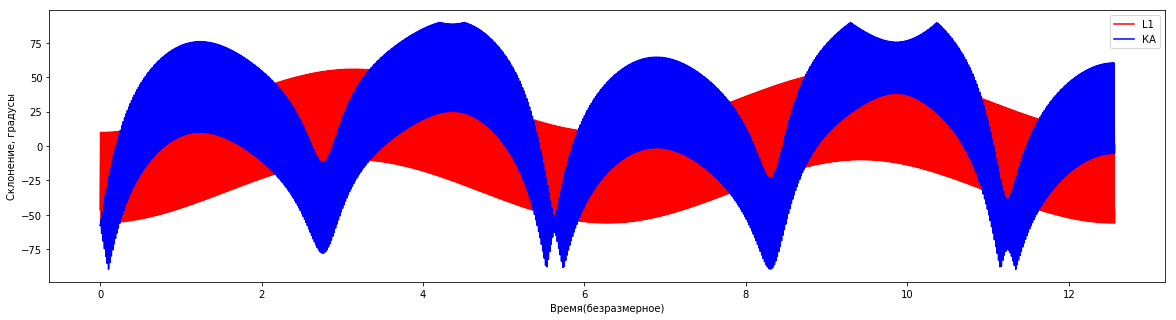

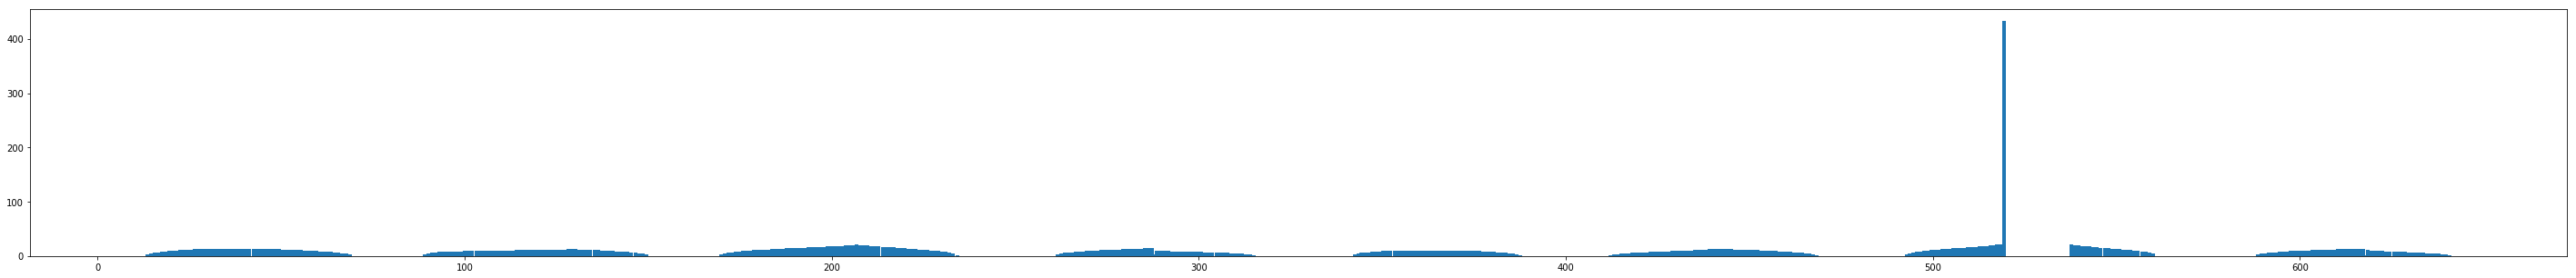

In [19]:
visarr = visibility(s1, [57, 38], 4*np.pi, 80.80555555555556)

In [ ]:
def delta_t_vary(visarr, delta_t_beg, dt, vary_count):
    Y_i = []
    dt1 = scale(dt, 'min-nd')
    for i in range(vary_count):
        itog = visarr[0:N - int(scale(delta_t_beg + i, 'd-min'))] & visarr[int(scale(delta_t_beg + i, 'd-min')):N] 
        itog2 = [] # представление пересечения моментов (минут) видимости для двух КА 
        for j in range(N - int(scale(delta_t_beg + i, 'd-min'))):
            if itog[j] == True:
                itog2.append(1)
            else:
                itog2.append(-1)
        # поиск непрерывных интервалов видимости для двух КА
        mask = np.array(itog2)==1 
        idx = np.where(np.logical_not(mask))[0]
        lwr = (idx + 1)[:-1]
        upr = (idx - 1)[1:]
        mask1 = lwr <= upr
        lwr, upr = lwr[mask1], upr[mask1]
        intervals = np.vstack((lwr, upr)).T
        if itog2[0] == 1:
            i = 0
            while itog2[k] != -1:
                k += 1
            intervals = np.insert(intervals, 0, [0, k-1])
            intervals = intervals.reshape(int(len(intervals)/2), 2)
        #print(intervals)
        X = scale(intervals[:,0]*dt1, 'nd-d')
        Y = scale((intervals[:, 1] - intervals[:, 0])*dt1, 'nd-h') # величины непрерывных интервалов 
        # отображение непрерывных интервалов видимости для пересечения 
        plt.figure(figsize=(50,5))
        plt.bar(X,Y, width = 1)
        print(delta_t_beg + i)
        plt.show()
        Y_i.append(Y)
    return(Y_i)


In [24]:
def delta_t_vary2(visarr, delta_t_beg, vary_count, time):
    Y_i = []
    #dt1 = scale(dt, 'min-nd')
    N = int(scale(time, 'nd-min'))
    for i in range(vary_count):
        itog = visarr[0:N - int(scale(delta_t_beg + i, 'd-min'))] & visarr[int(scale(delta_t_beg + i, 'd-min')):N] 
        lenn = len(itog)//(24*60)
        for_bar = itog[:lenn*24*60].reshape(lenn, 24*60)
        YY = np.mean(for_bar, axis = 1)*24
        plt.figure(figsize = (30,5))
        plt.bar(range(lenn),YY)
        print(delta_t_beg + i)
        plt.show()
        Y_i.append(YY)
    return(Y_i)

In [ ]:
Y_i = delta_t_vary(visarr, 80.80555555555556, 0.9999999999999999, 10)

In [ ]:
#существует естественная динамика. мы исследуем некоторые особенности этой динамики. вычленяем взаимосвязи. это фундаментальный базис проектирования космических миссий. использование общей модели смазывает результаты

80.80555555555556


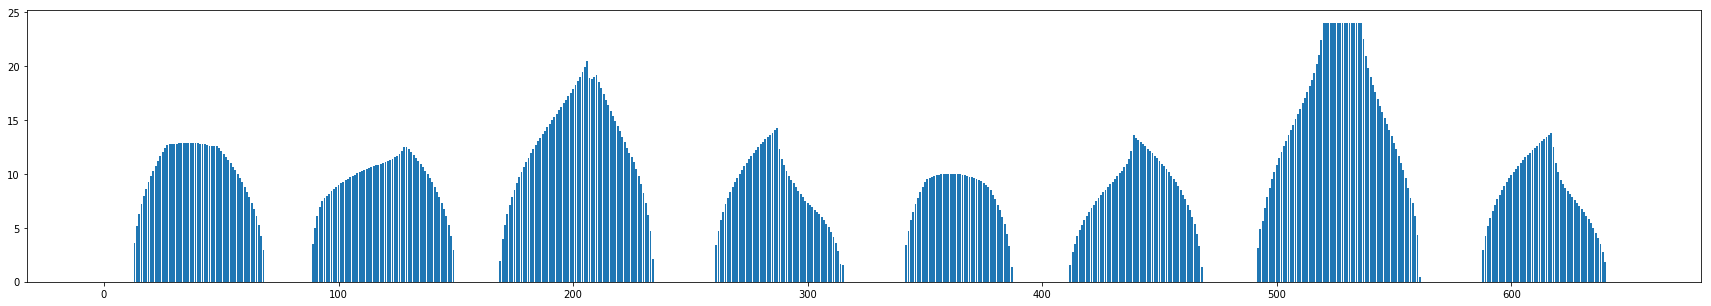

81.80555555555556


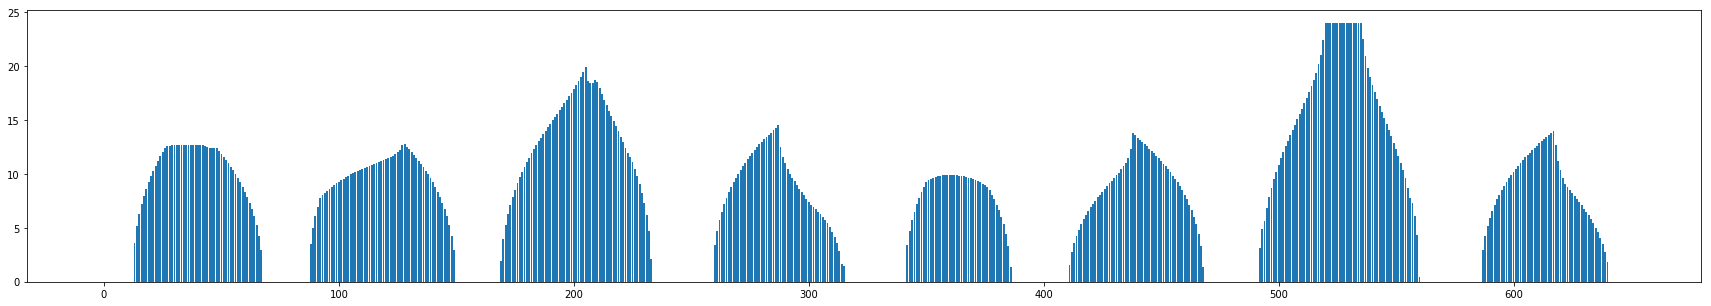

82.80555555555556


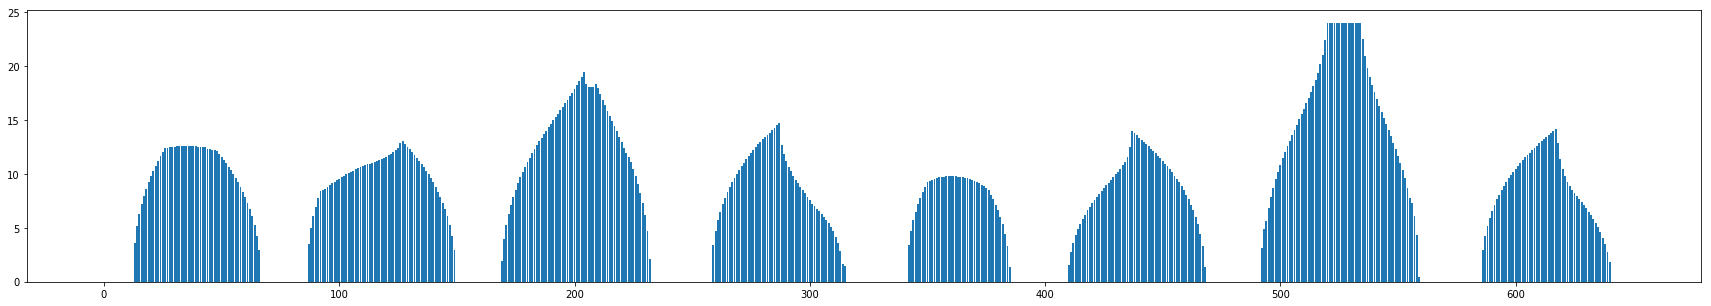

83.80555555555556


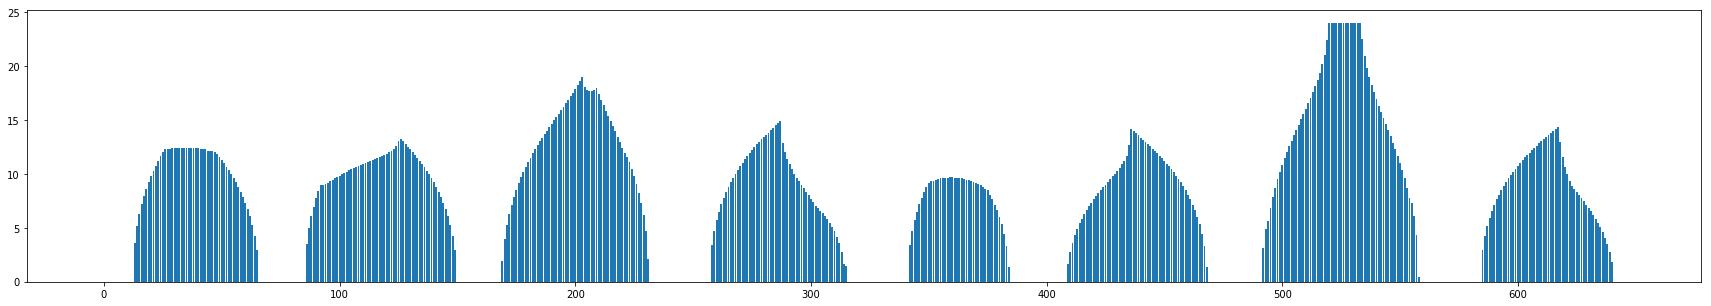

84.80555555555556


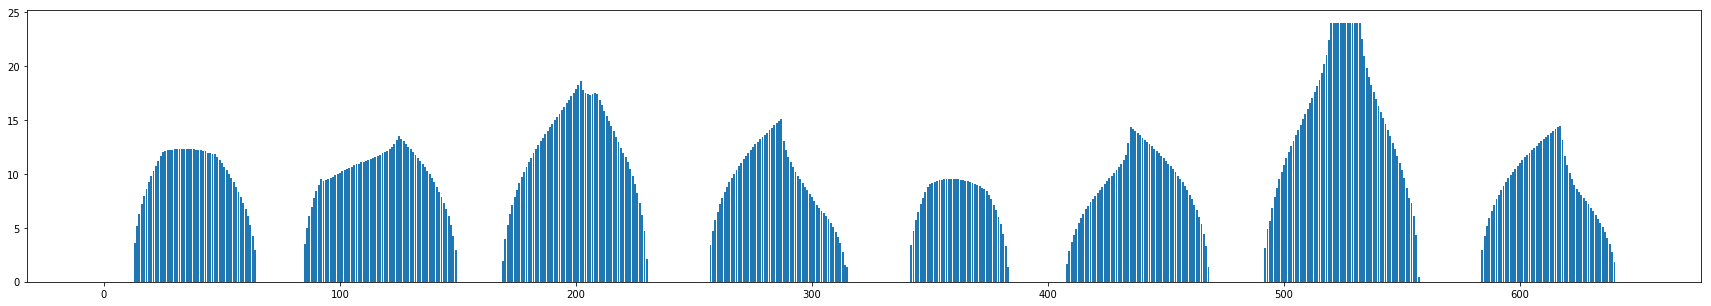

85.80555555555556


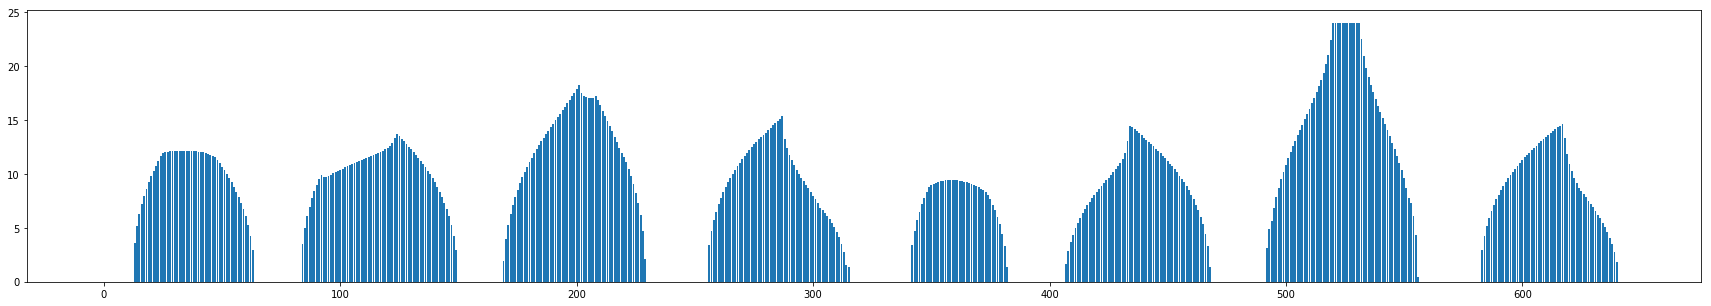

86.80555555555556


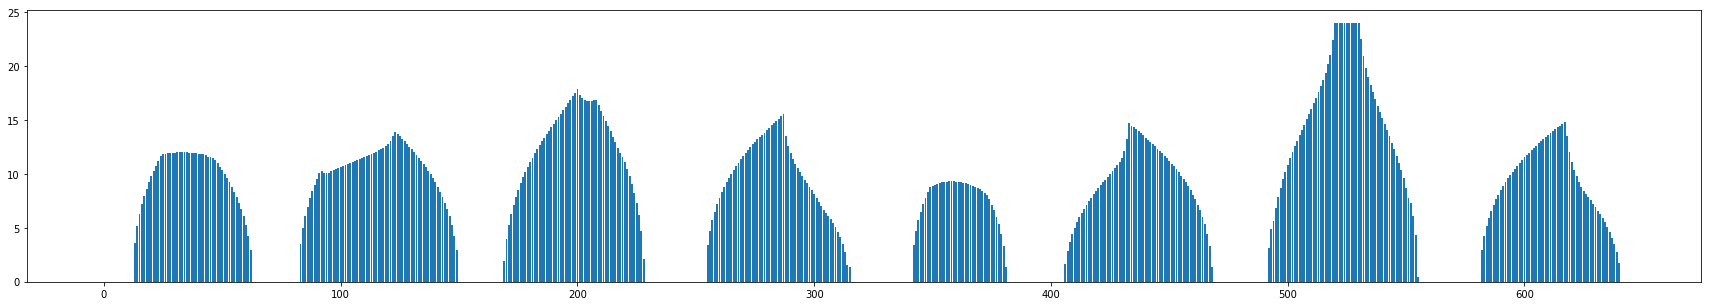

87.80555555555556


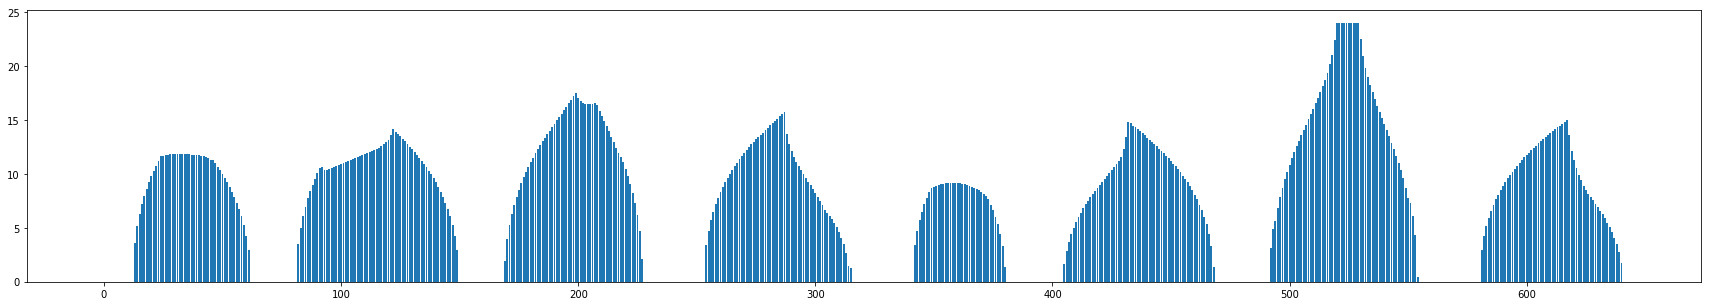

88.80555555555556


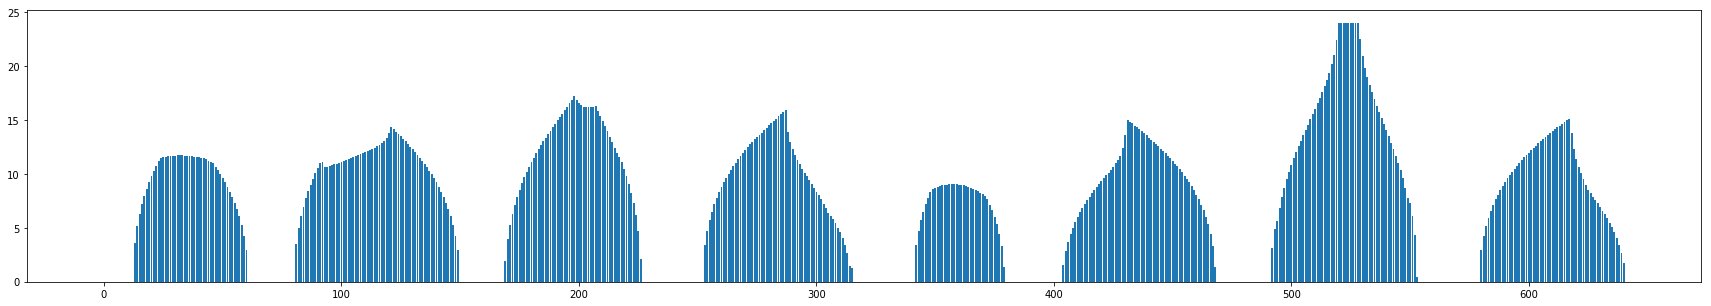

89.80555555555556


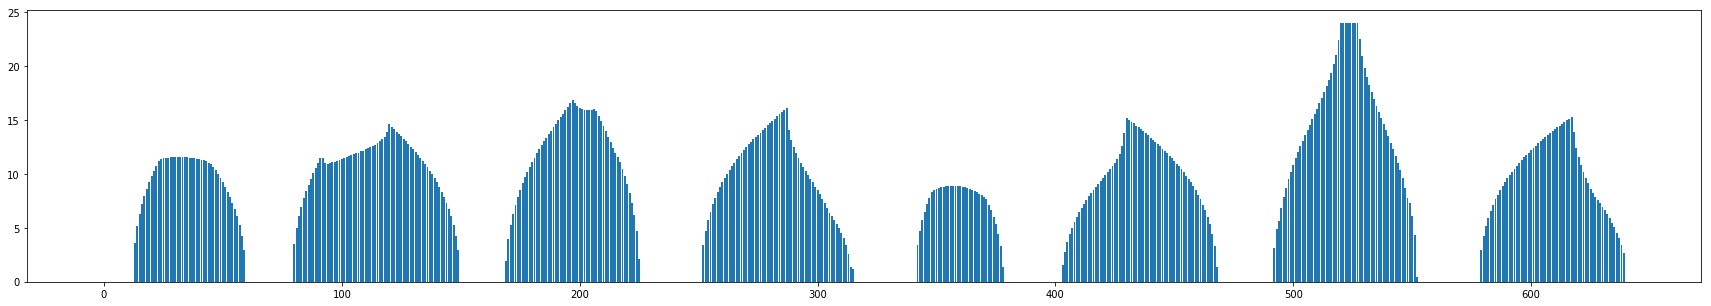

In [25]:
Y_i2 = delta_t_vary2(visarr, 80.80555555555556, 10, 4*np.pi)

In [26]:
Y_i3 = []
for i in range(10):
    tmp = np.where(Y_i2[i]<=2, 0, Y_i2[i])
    Y_i3.append(tmp)
    non_visible = len(tmp) - np.count_nonzero(tmp)
    print(non_visible)

193
192
191
190
189
188
187
186
185
184


In [ ]:
df = sk.prop(0.0, s0, 1)

In [28]:
event = op.eventY(count =2)            

det = op.event_detector(model, [event])
df, ev = det.prop(s1, 0.0, 300)
df

,t,x,y,z,vx,vy,vz
0,0.000000,0.997861,0.000000,-0.004845,0.000000,-0.028418,0.000000
1,0.017214,0.997858,-0.000489,-0.004830,-0.000345,-0.028327,0.001765
2,0.034428,0.997849,-0.000974,-0.004785,-0.000690,-0.028058,0.003500
3,0.051643,0.997834,-0.001454,-0.004710,-0.001036,-0.027621,0.005179
4,0.068857,0.997813,-0.001924,-0.004607,-0.001382,-0.027029,0.006777
5,0.086071,0.997787,-0.002384,-0.004477,-0.001727,-0.026303,0.008275
6,0.103285,0.997754,-0.002829,-0.004323,-0.002072,-0.025463,0.009660
7,0.120499,0.997715,-0.003260,-0.004145,-0.002414,-0.024531,0.010923
8,0.137714,0.997671,-0.003673,-0.003947,-0.002752,-0.023527,0.012061
9,0.154928,0.997621,-0.004069,-0.003731,-0.003086,-0.022472,0.013075


In [29]:
tlast = df['t'].iloc[-1]
scale(tlast/2, 'nd-d')

81.49999999999976

In [ ]:
halo = pd.read_csv('halo family SE L1.txt', sep=' ', header=None, comment = '#')
halo.columns = ['x', 'z', 'vy']
halo['z'] = -1*halo['z']
halo = halo.loc[~halo.apply(np.round, args=[9]).duplicated()]

<BarContainer object of 729 artists>

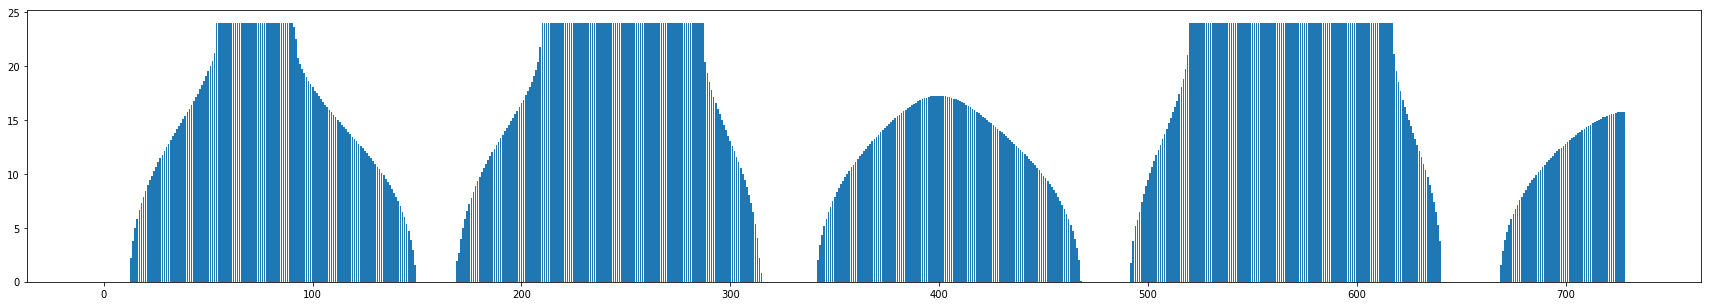

In [32]:
#visarr = np.array(visibility)
itog = visarr[0:N - int(81.49999999999976)] & visarr[int(81.49999999999976):N] # сдвиг траектории второго КА относительно первого составляет 125000 минут, ,что примерно равно четверти года (половине периода орбиты)
lenn = len(itog)//(24*60)
for_bar = itog[:lenn*24*60].reshape(lenn, 24*60)
YY = np.mean(for_bar, axis = 1)*24
plt.figure(figsize = (30,5))
plt.bar(range(lenn),YY)

In [27]:
N = int(scale(4*np.pi, 'nd-min'))

In [37]:
tmp = np.where(YY<=2, 0, YY)
non_visible = len(tmp) - np.count_nonzero(tmp)
print(non_visible, non_visible/np.count_nonzero(tmp))

116 0.18923327895595432


In [35]:
tmp

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  2.25      ,  3.81666667,
        4.96666667,  5.85      ,  6.61666667,  7.3       ,  7.88333333,
        8.45      ,  8.95      ,  9.41666667,  9.85      , 10.28333333,
       10.66666667, 11.06666667, 11.43333333, 11.78333333, 12.15      ,
       12.48333333, 12.81666667, 13.15      , 13.48333333, 13.8       ,
       14.13333333, 14.45      , 14.76666667, 15.1       , 15.41666667,
       15.75      , 16.06666667, 16.41666667, 16.75      , 17.1       ,
       17.45      , 17.83333333, 18.23333333, 18.63333333, 19.08333333,
       19.55      , 20.01666667, 20.43333333, 21.21666667, 24.        ,
       24.        , 24.        , 24.        , 24.        , 24.        ,
       24.        , 24.        , 24.        , 24.        , 24.        ,
       24.        , 24.        , 24.        , 24.        , 24.  

In [39]:
halo = pd.read_csv('halo family SE L1.txt', sep=' ', header=None, comment = '#')
halo.columns = ['x', 'z', 'vy']
halo['z'] = -1*halo['z']

In [59]:
haloo = np.array(halo)

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


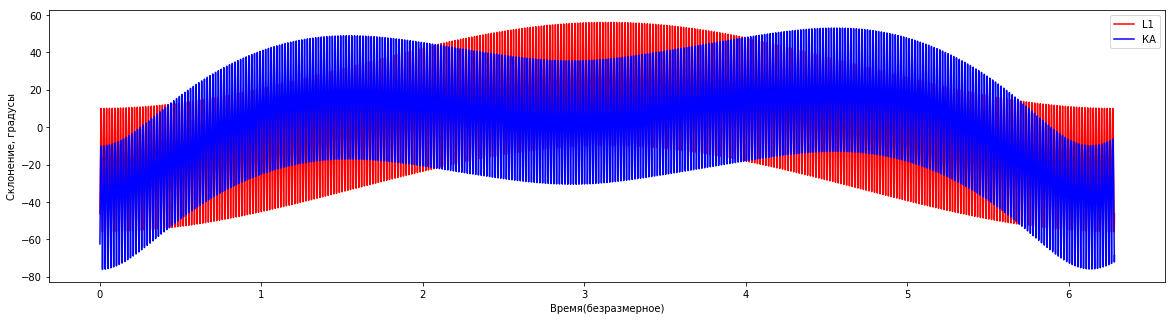

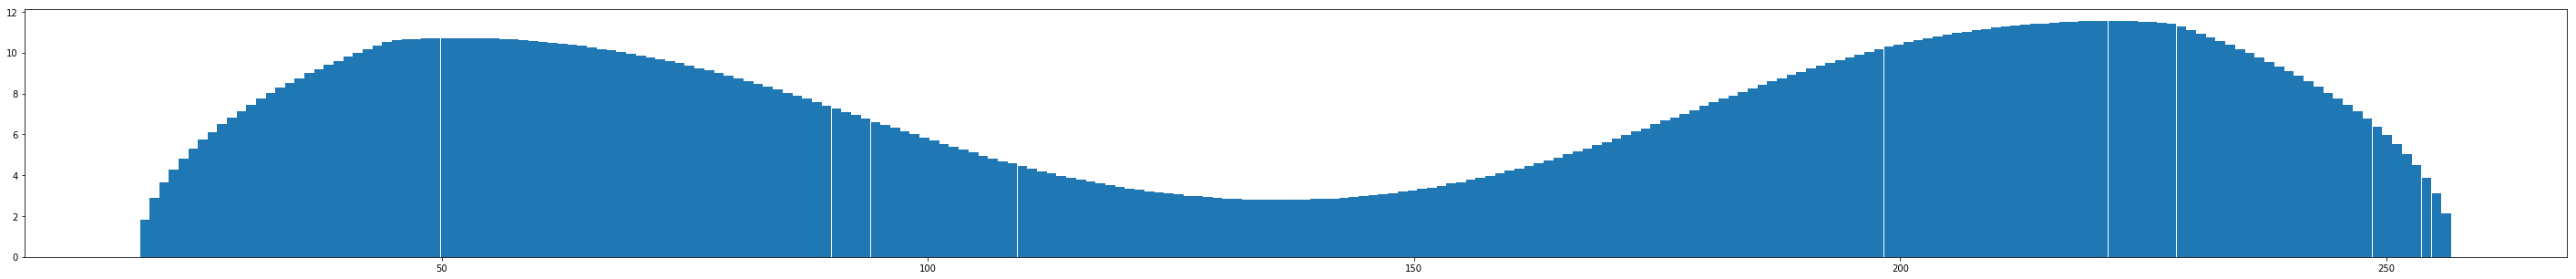

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


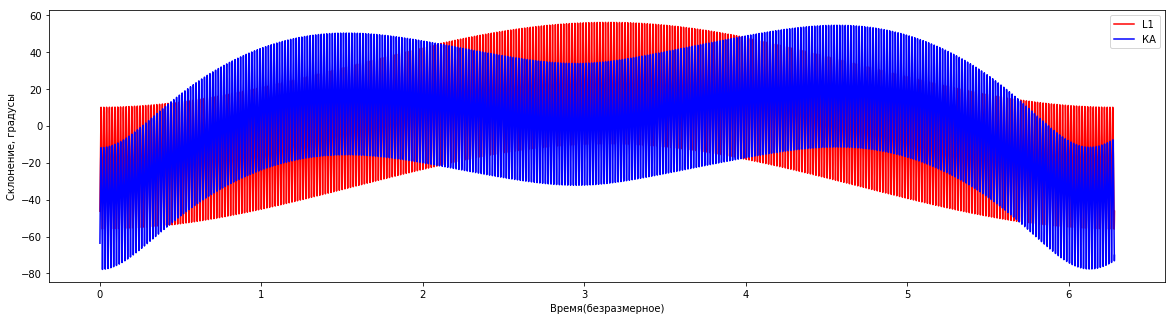

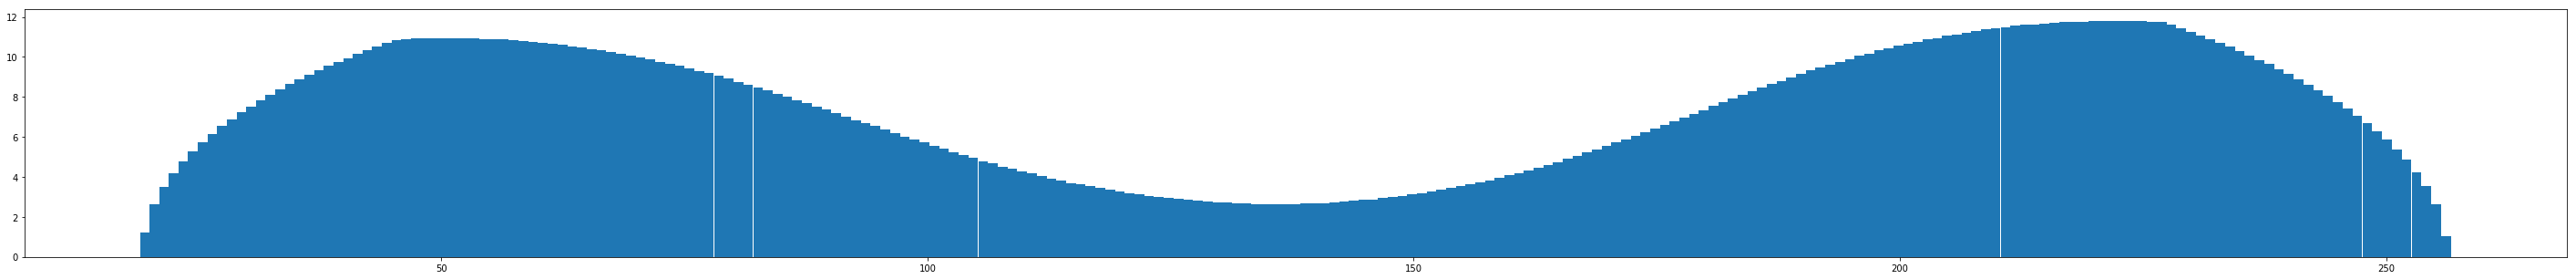

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


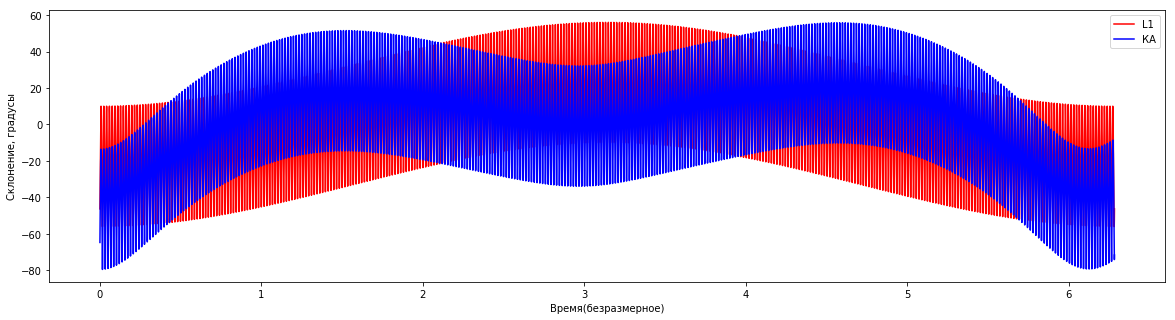

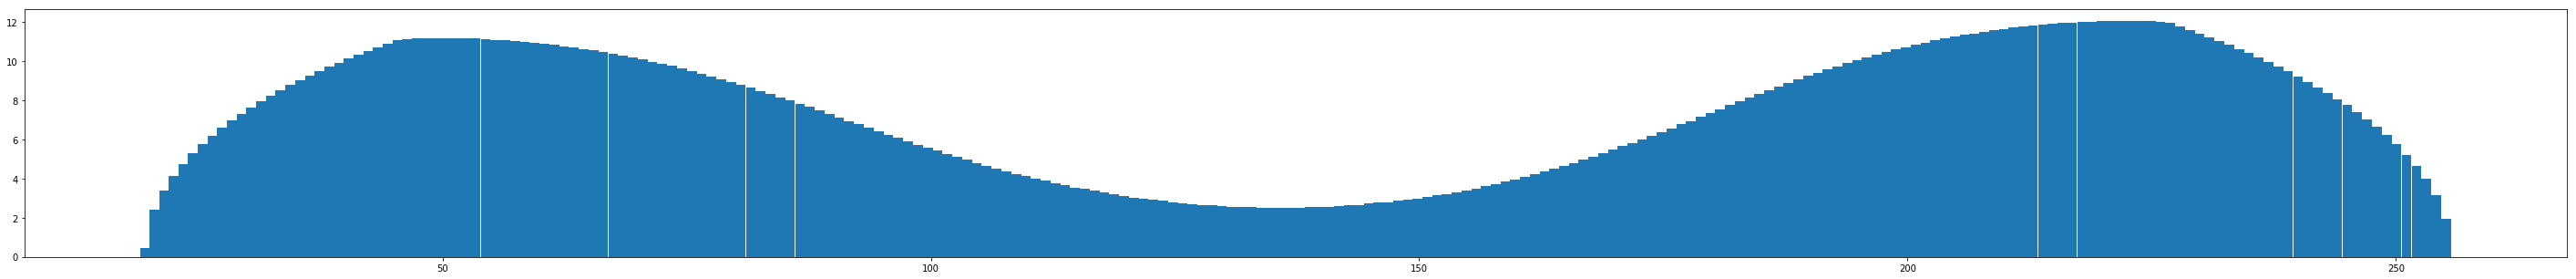

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


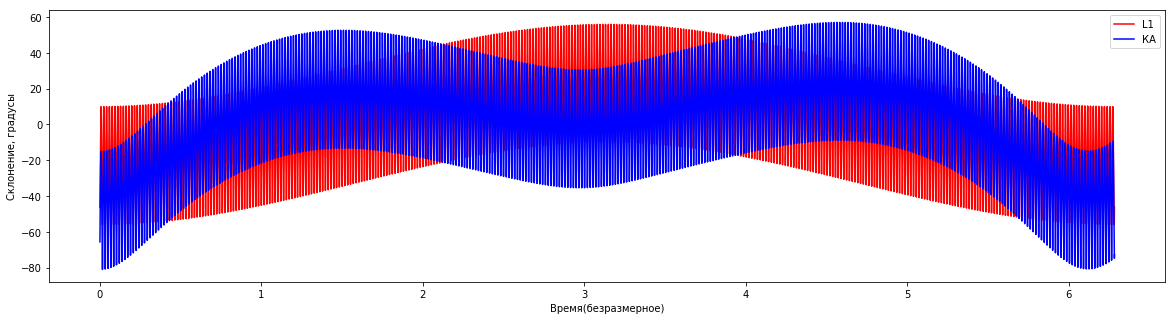

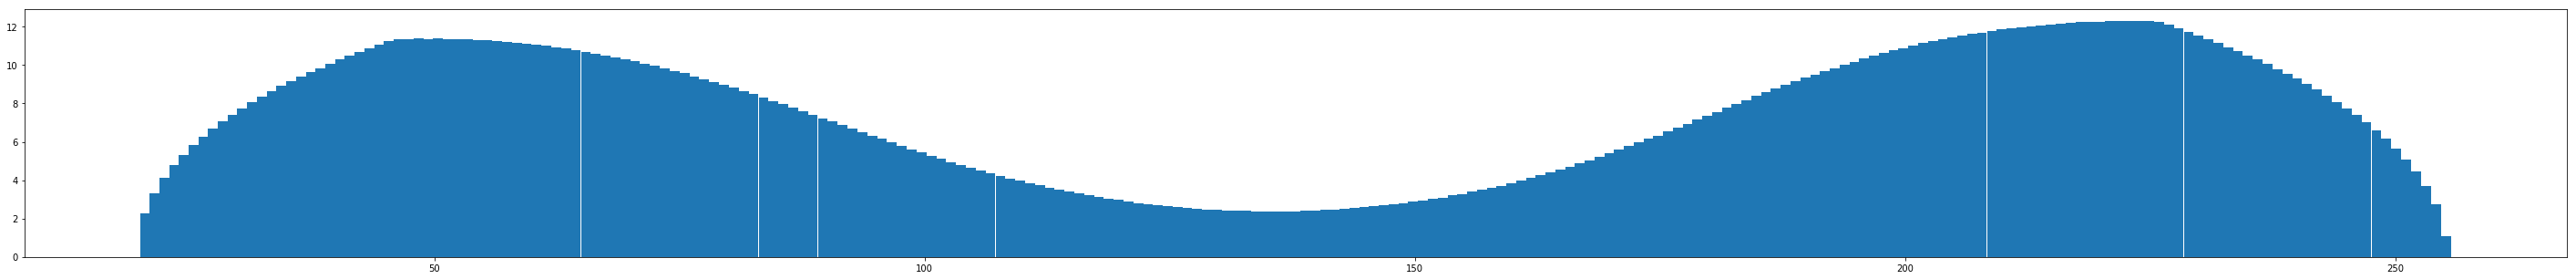

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


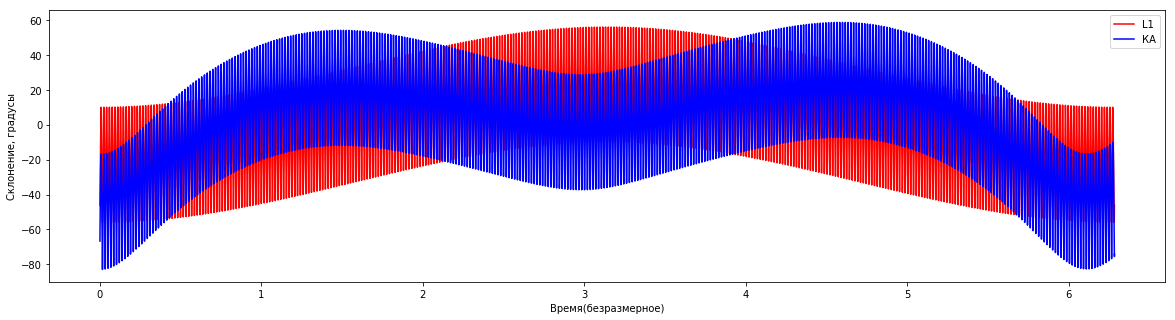

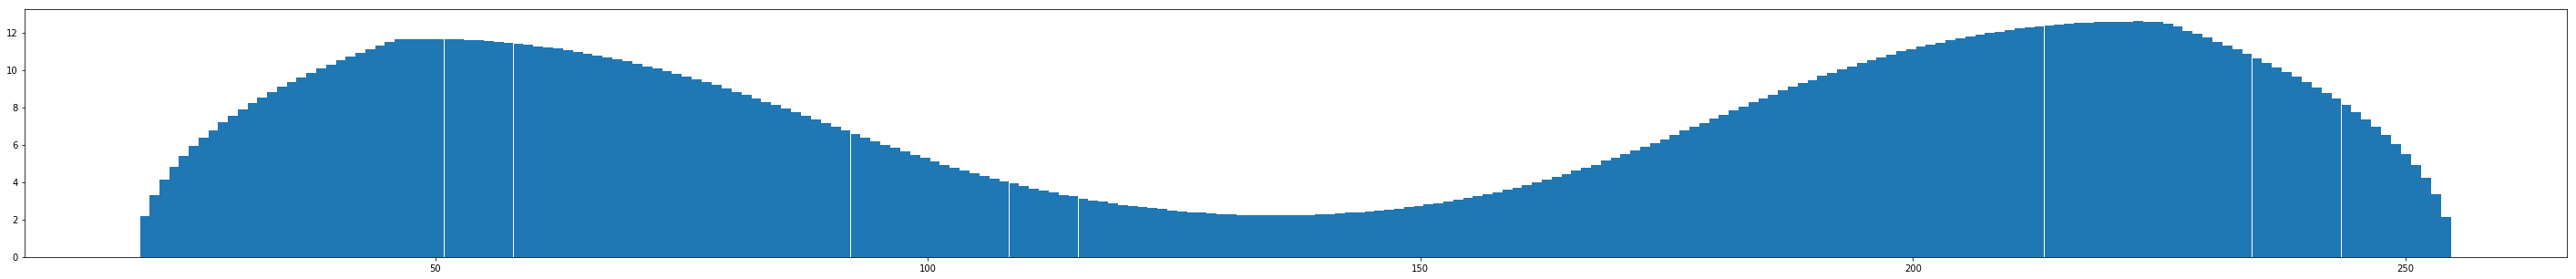

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


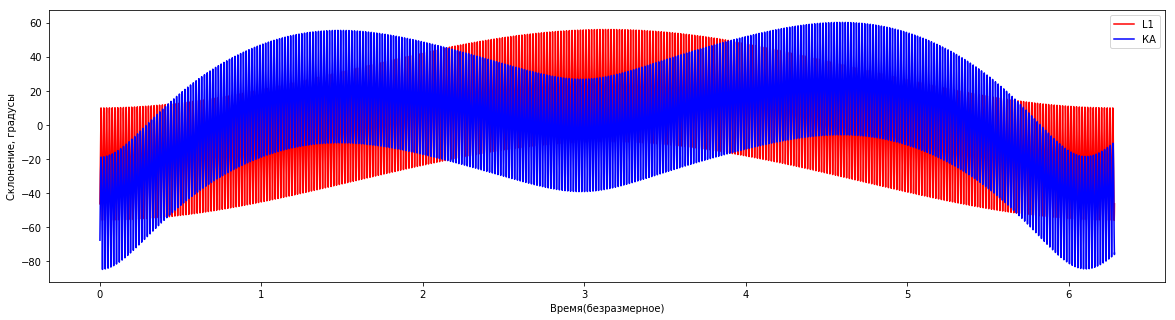

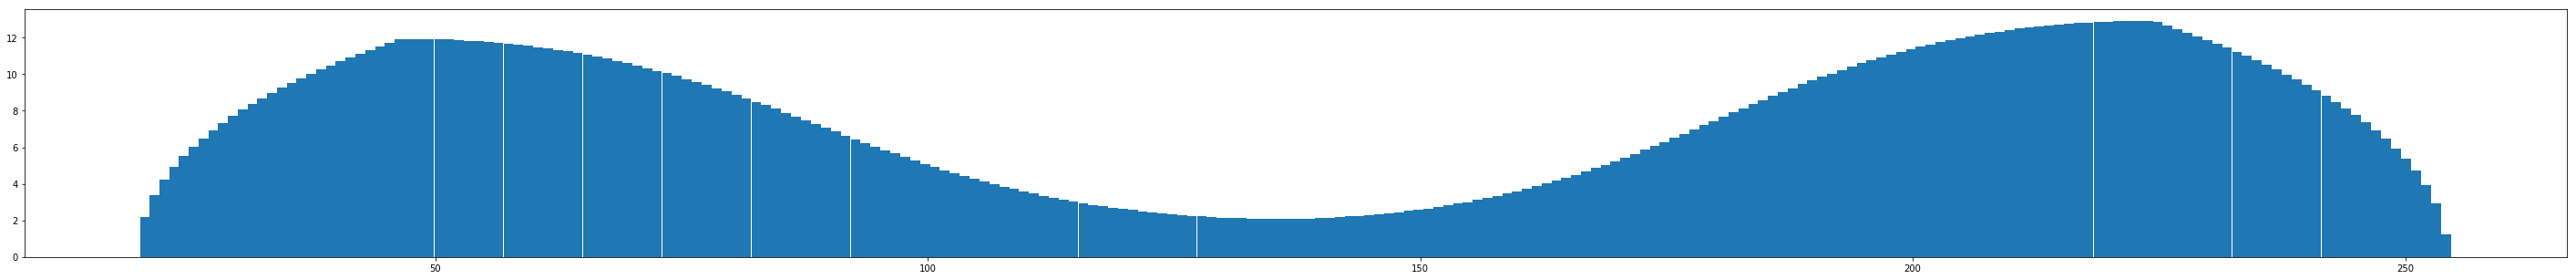

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


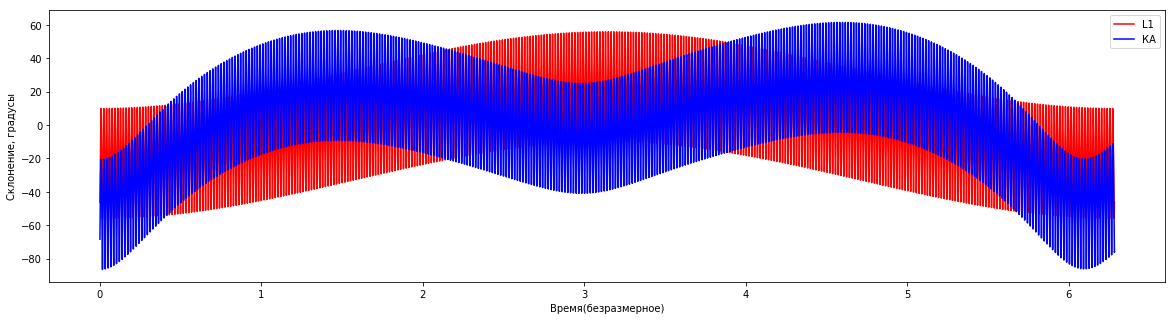

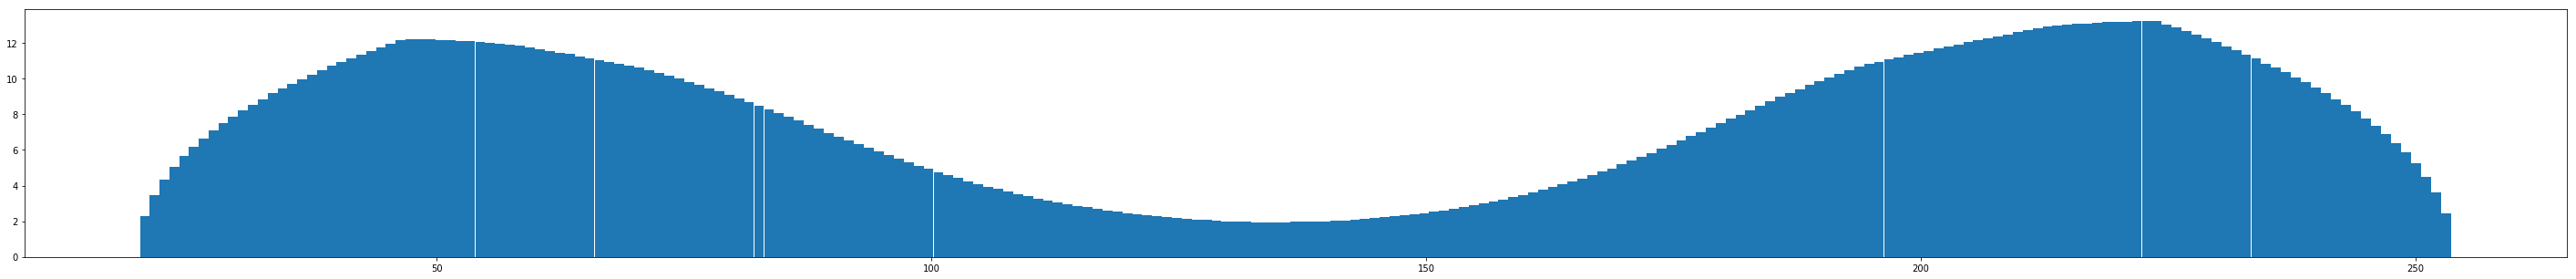

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


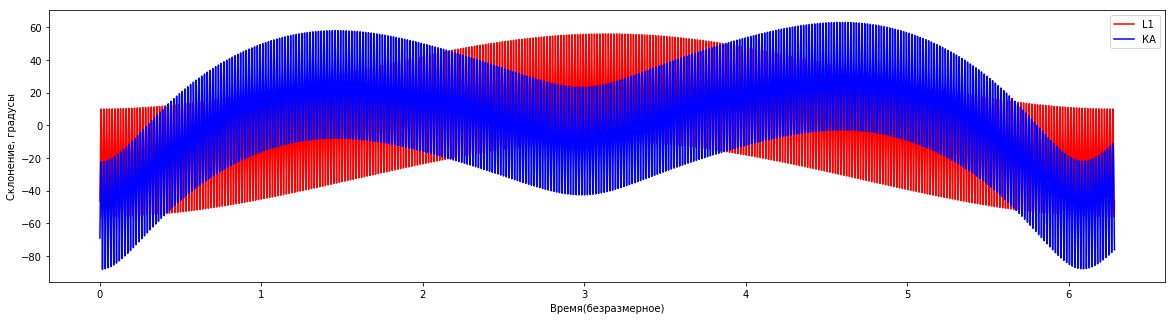

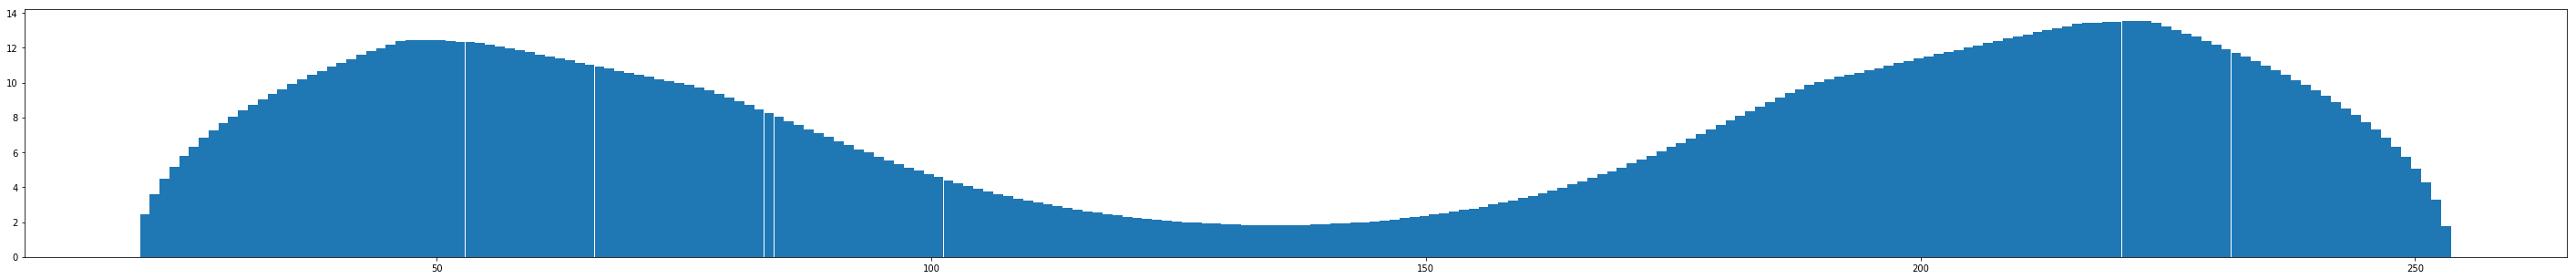

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


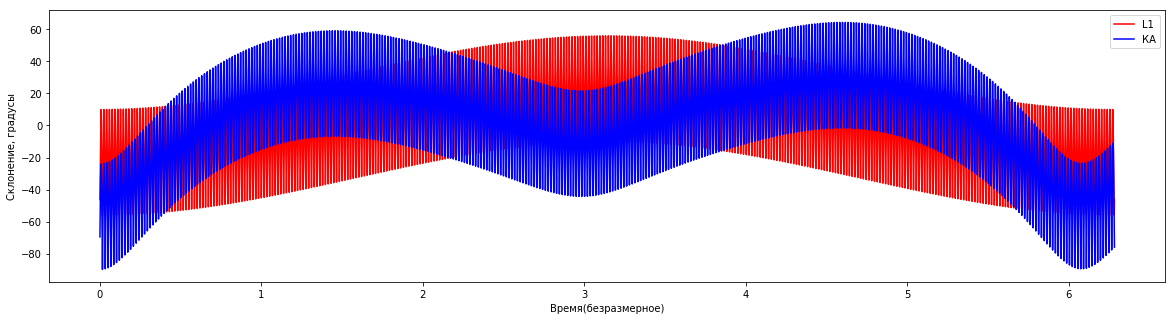

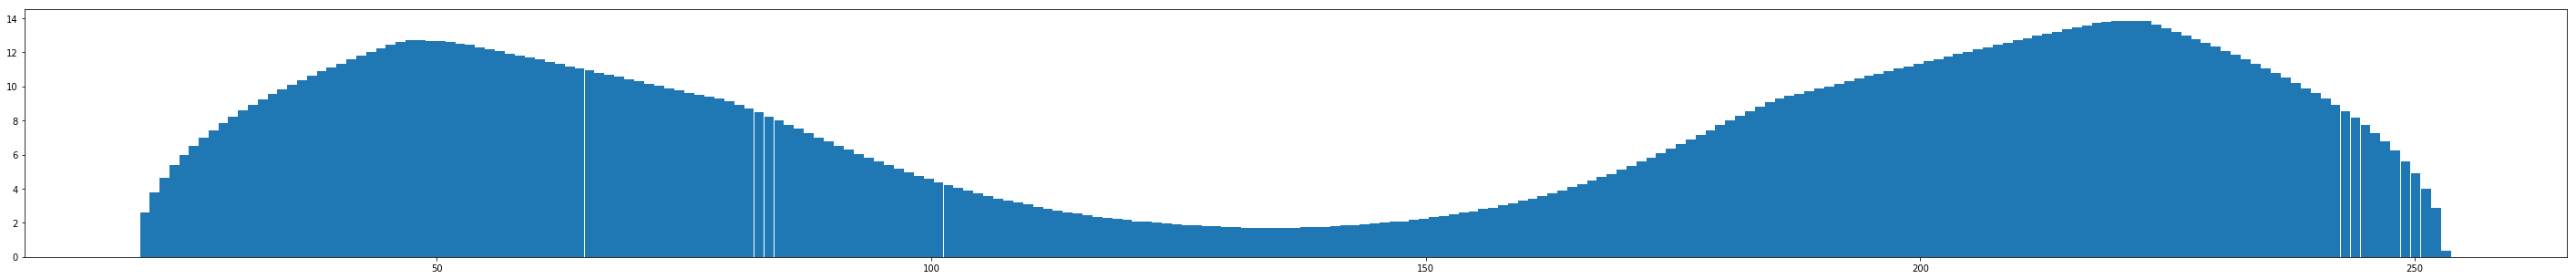

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


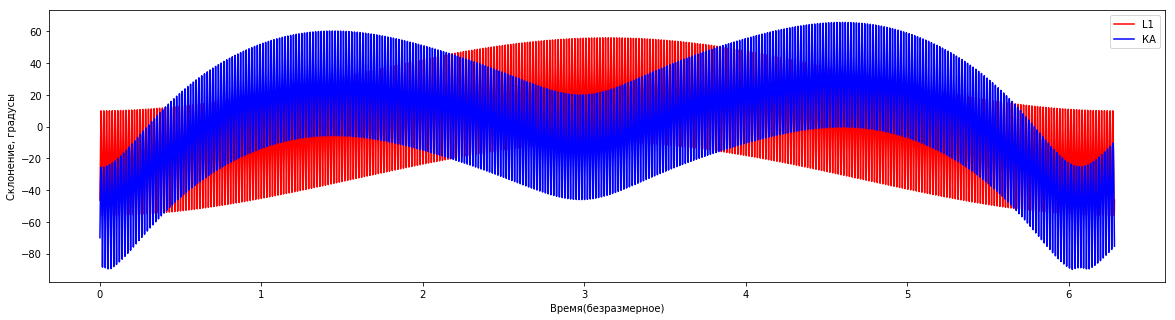

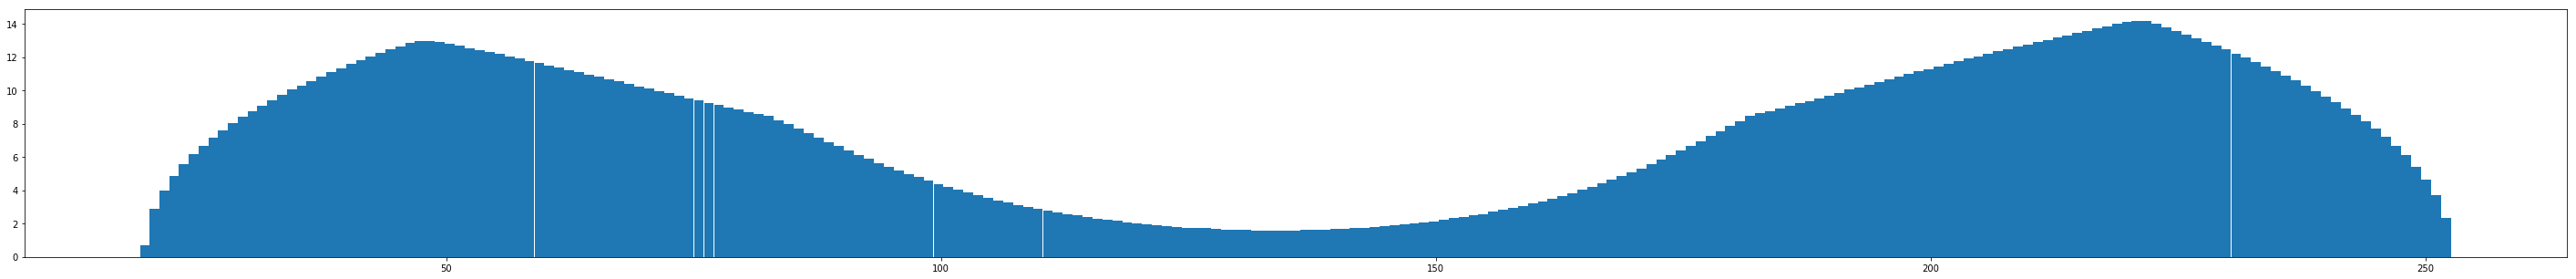

In [65]:
for i in range(10):
    ss = model.get_zero_state()
    ss[0] = haloo[300+50*i, 0]
    ss[2] = haloo[300+50*i, 1]
    ss[4] = haloo[300+50*i, 2]
    visibility(ss, [57,38], 2*np.pi, 81)

In [71]:
def visibility2(s, coord, time, delta_t, ax = ax0, alpha = 5):
    
    right = op.eventX(1.-model.mu)
    left = op.eventX(model.L1 - 1500000/model.R)
    first_corr = op.border_correction(model, op.y_direction(), [left], [right])
    corr = op.border_correction(model, op.y_direction(), [left], [right])
    sk = op.simple_station_keeping(pmodel, first_corr, corr)
    df_needed = sk.prop(0.0, s, int(time/np.pi))    
    spl = op.lines.spline.cubic(df_needed[['t','x','y','z']].to_numpy(), usecols=(0,)) 
    
    tmin = df_needed['t'].iloc[0]
    tmax = df_needed['t'].iloc[-1]

    N = int(scale(time, 'nd-min'))
    dt1 = (tmax-tmin)/N # одна минута*
    dt = scale(dt1, 'nd-min') 
    #print("dt(min) = ", dt)
    array = spl.get_points(N) # интерполяция траектории (координаты на каждую минуту*)
    print('beg')
    norm0 = np.array([math.cos(coord[0]*np.pi/180)*math.cos(coord[1]*np.pi/180), math.cos(coord[0]*np.pi/180)*math.sin(coord[1]*np.pi/180), math.sin(coord[0]*np.pi/180)])
    sc_dec_norm = [] # склонение КА 
    l1_dec_norm = [] # склонение L1
    visibility = []
    for i in range(N): 
        sc_cur1 = array[i]
        sc_dec_norm.append(angle_norm(sc_cur1[1:], norm0, sc_cur1[0])) 
        l1_dec_norm.append(angle_norm(model.L[0], norm0, sc_cur1[0]))
        if (sc_dec_norm[i] >= alpha and sc_dec_norm[i] < 90):
            visibility.append(True)
        else:
            visibility.append(False)
    #
    print('end')
        
    # сравнение склонений КА и L1   
    plt.figure(figsize = (20,5))
    plt.plot(array[:,0], l1_dec_norm, 'r', label = 'L1')
    plt.plot(array[:,0], sc_dec_norm, 'b', label = 'КА')
    plt.xlabel("Время(безразмерное)")
    plt.ylabel("Склонение, градусы")
    plt.legend()
    #
    visarr = np.array(visibility)
    itog = visarr[0:N - int(scale(delta_t, 'd-min'))] & visarr[int(scale(delta_t, 'd-min')):N] # сдвиг траектории второго КА относительно первого составляет 125000 минут, ,что примерно равно четверти года (половине периода орбиты)
    lenn = len(itog)//(24*60)
    for_bar = itog[:lenn*24*60].reshape(lenn, 24*60)
    YY = np.mean(for_bar, axis = 1)*24
    plt.figure(figsize = (30,5))
    plt.bar(range(lenn),YY)
    plt.show()
    tmp = np.where(YY<=2, 0, YY)
    non_visible = len(tmp) - np.count_nonzero(tmp)
    print(non_visible, non_visible/len(tmp))
    return(visarr)


Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


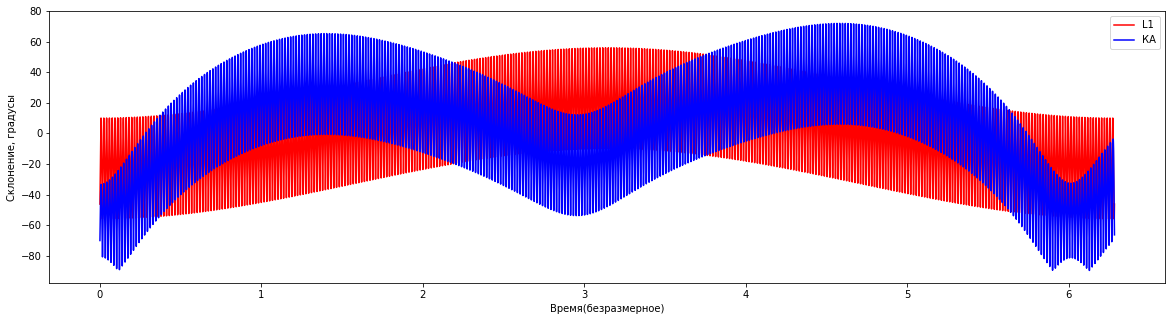

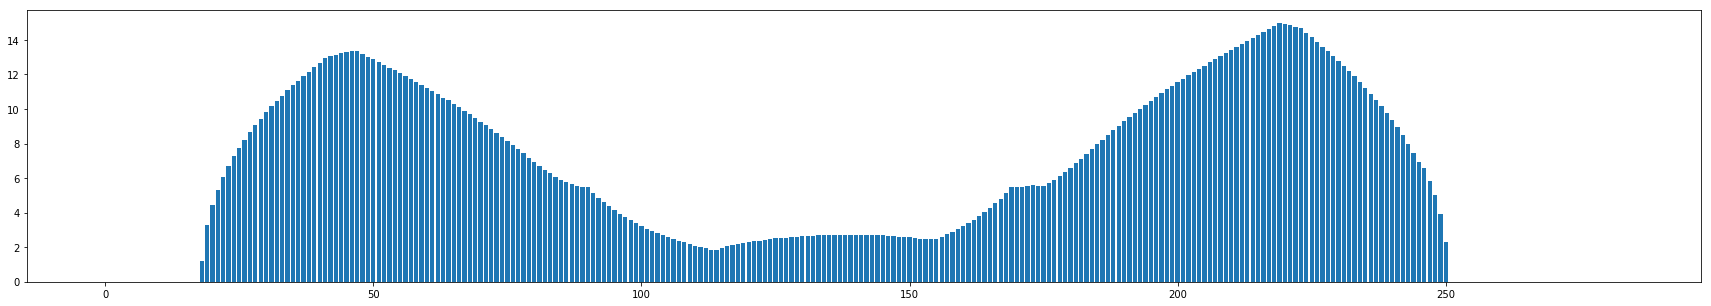

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


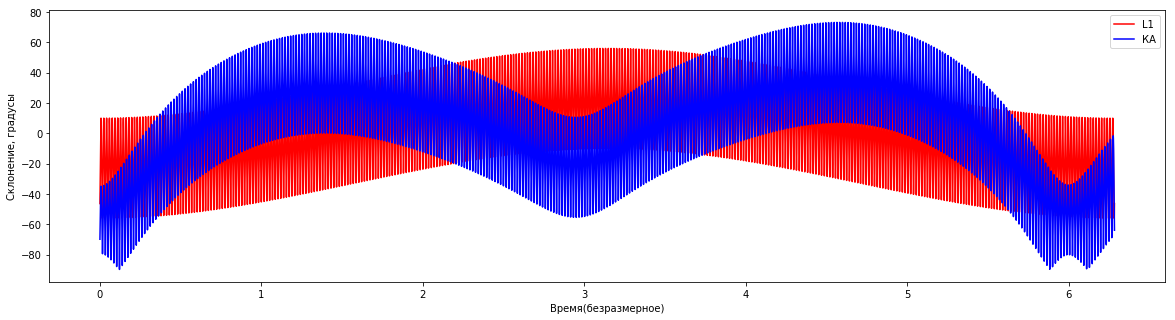

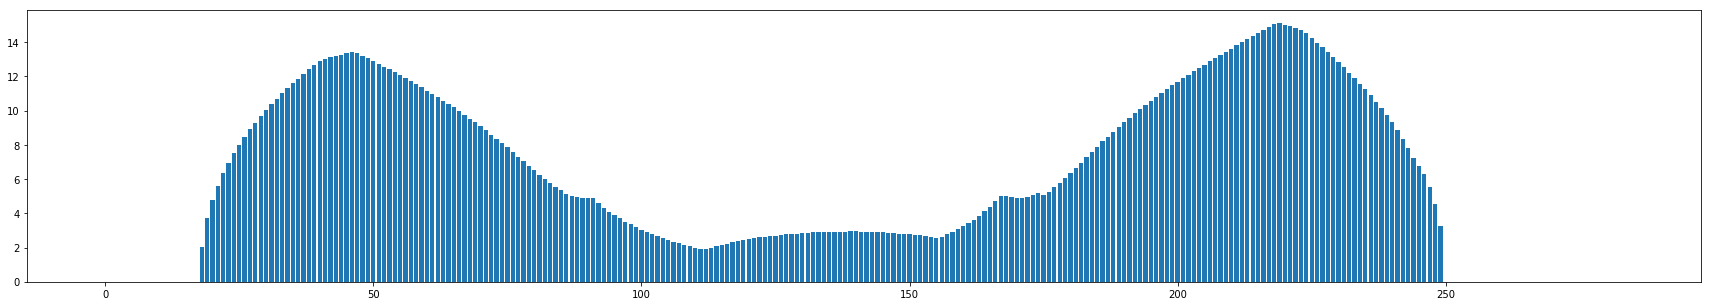

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


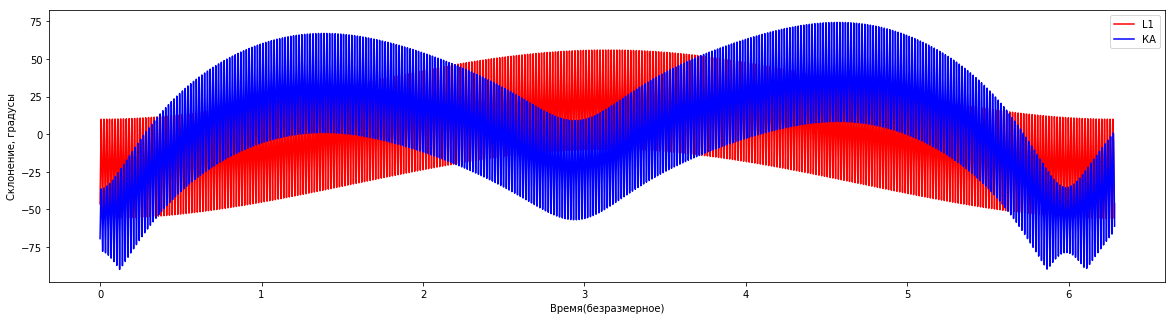

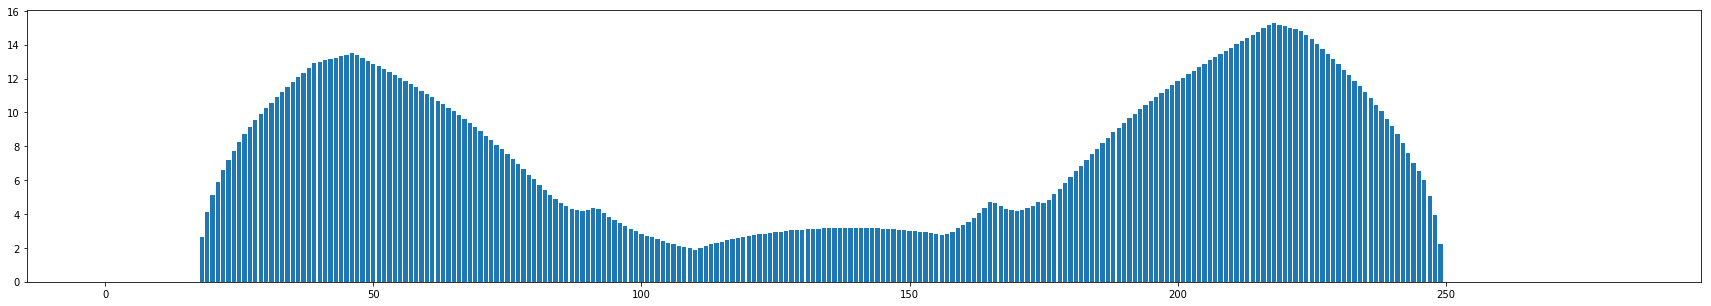

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


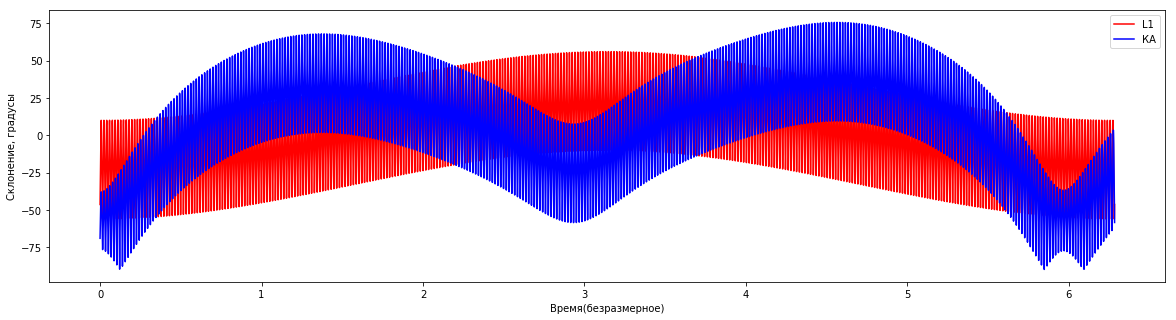

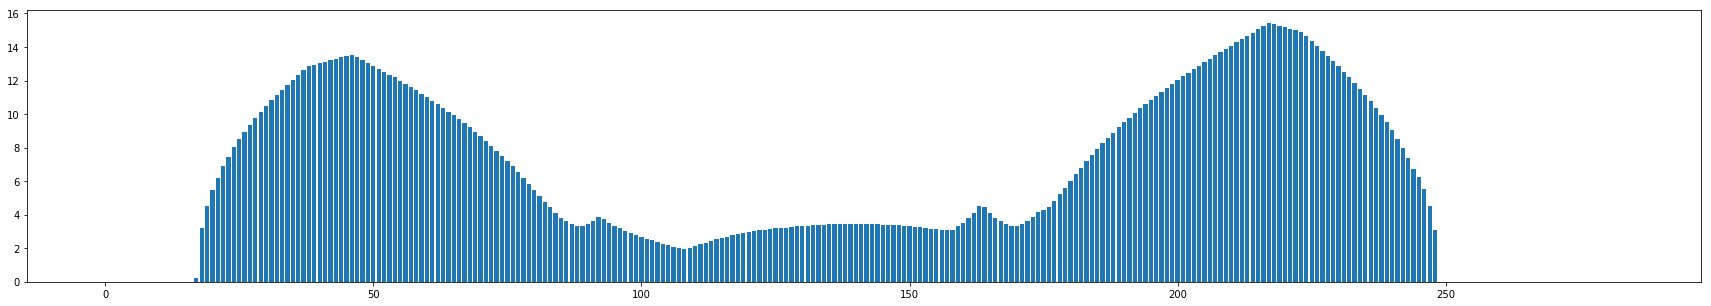

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


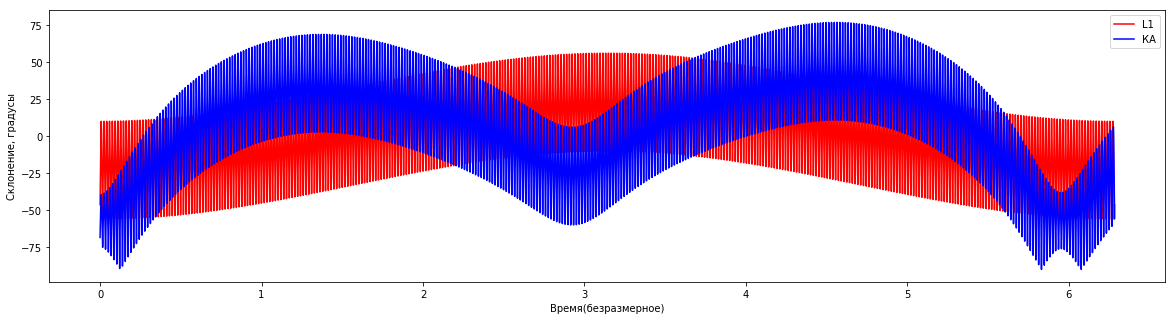

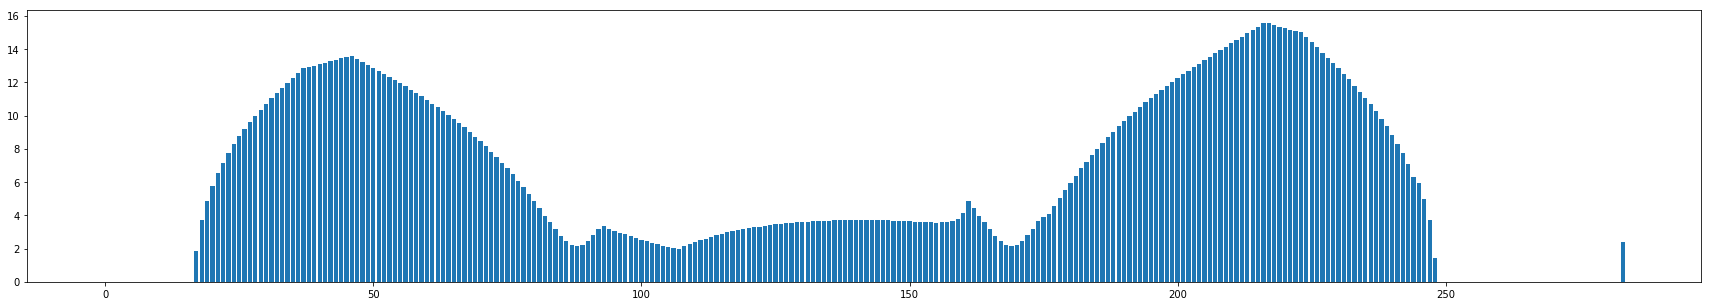

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


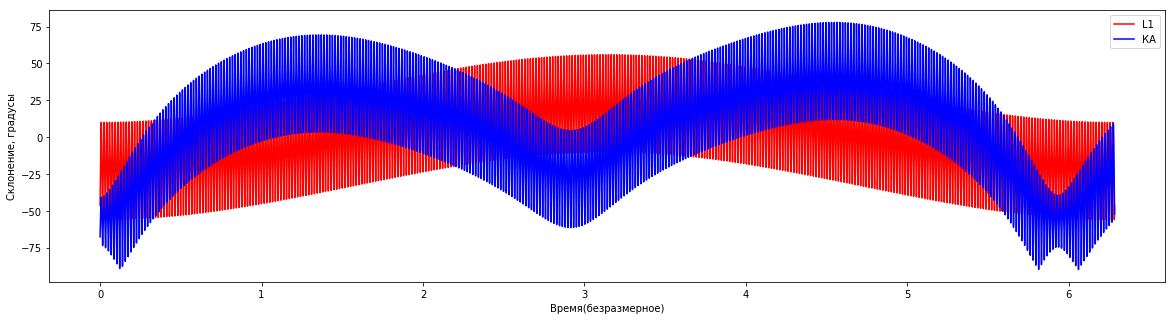

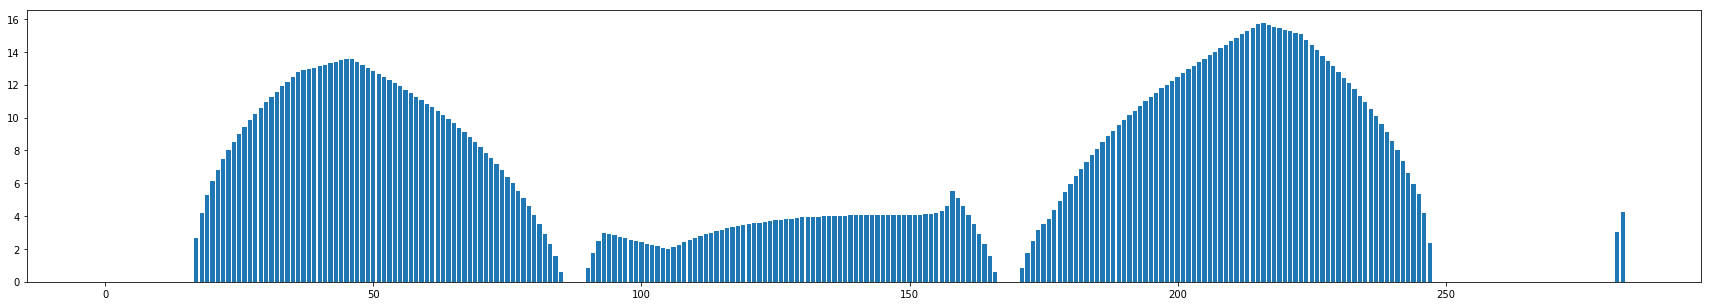

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


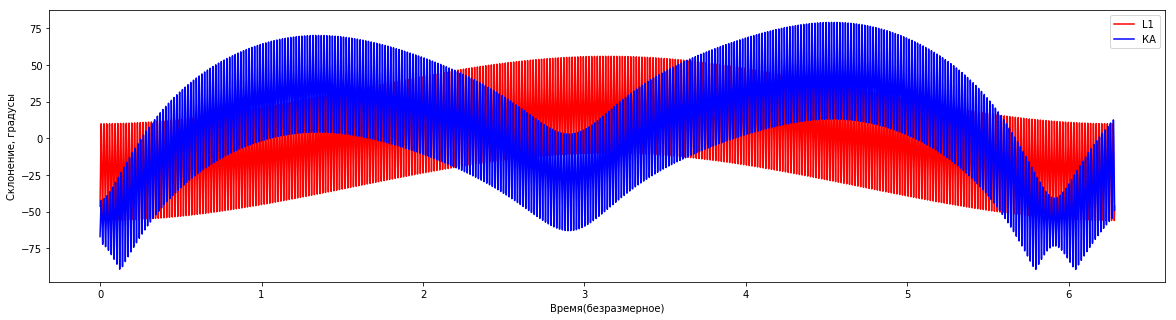

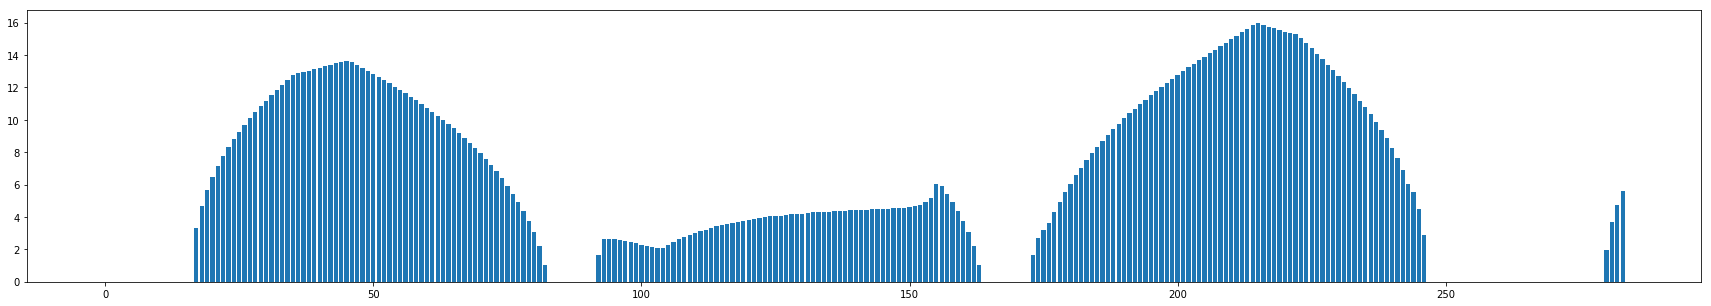

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


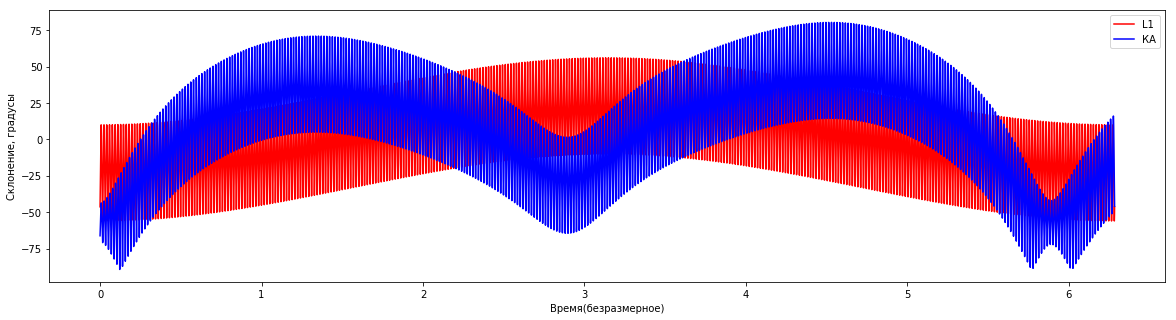

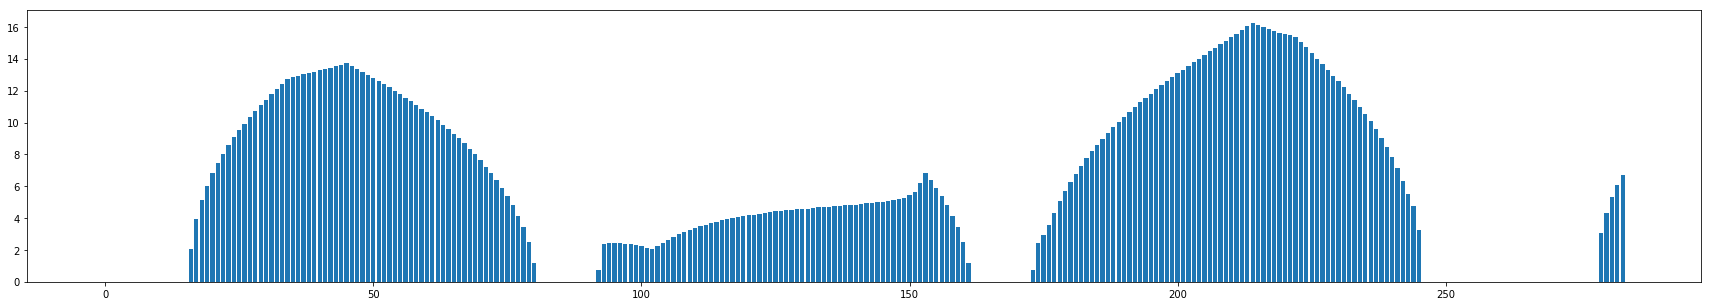

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


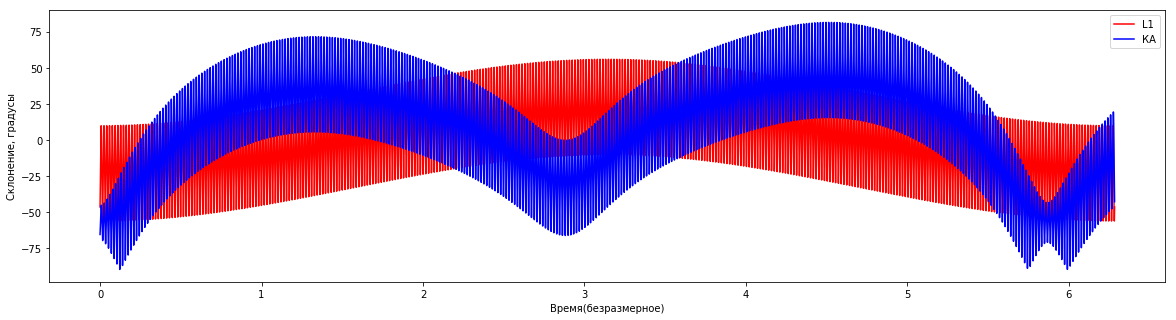

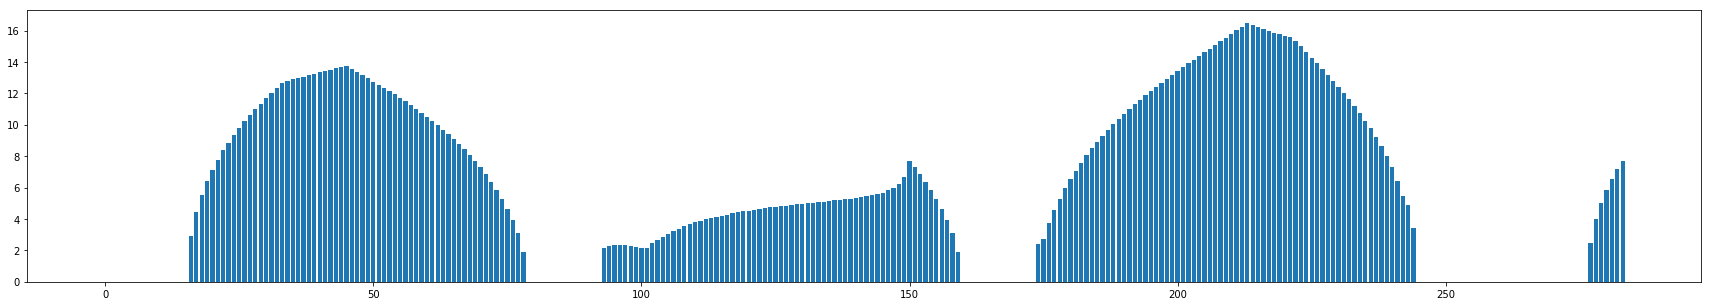

Simple station-keeping: 0 1 
dt(min) =  0.9999999999999999
beg
end


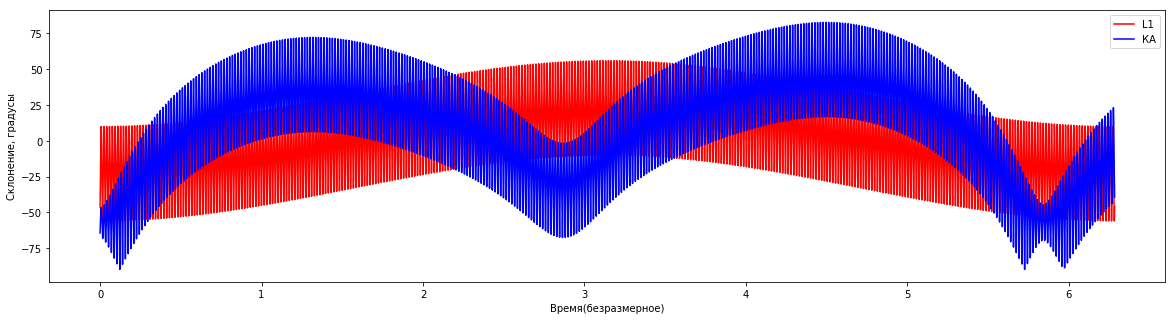

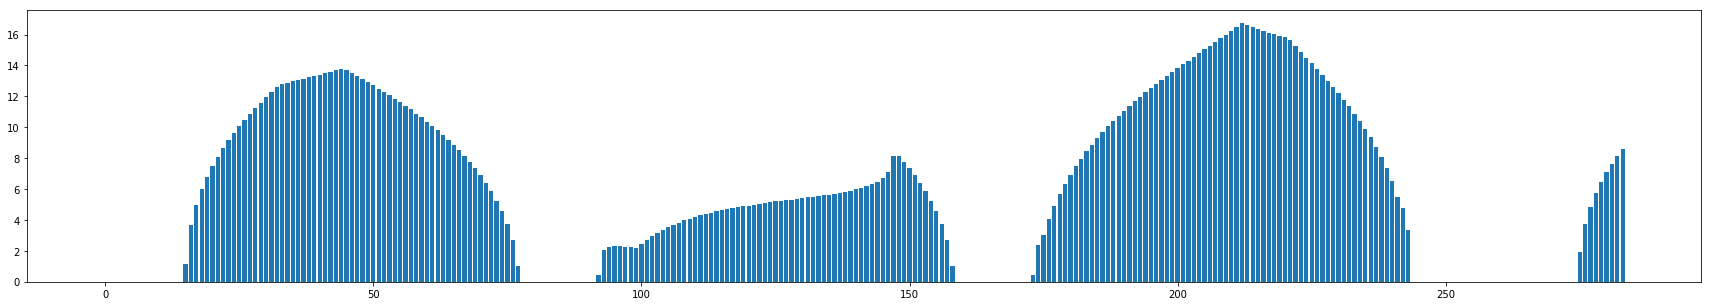

In [68]:
for i in range(10):
    ss = model.get_zero_state()
    ss[0] = haloo[1000+50*i, 0]
    ss[2] = haloo[1000+50*i, 1]
    ss[4] = haloo[1000+50*i, 2]
    visibility2(ss, [57,38], 2*np.pi, 81)

0
Simple station-keeping: 0 1 2 3 
beg
end


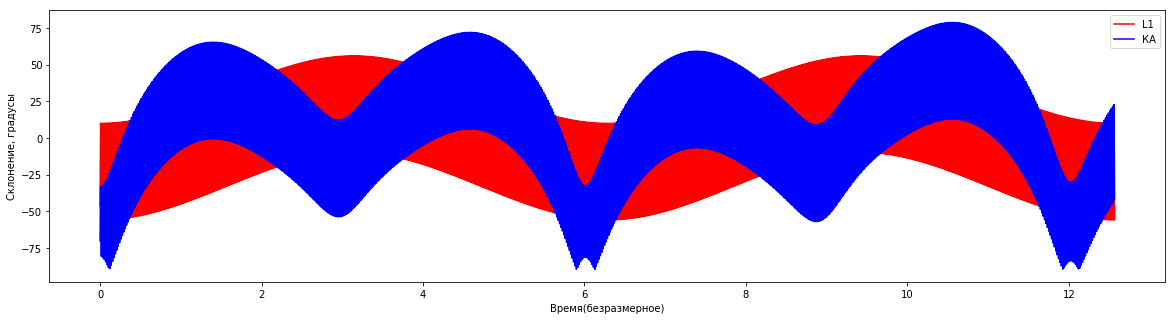

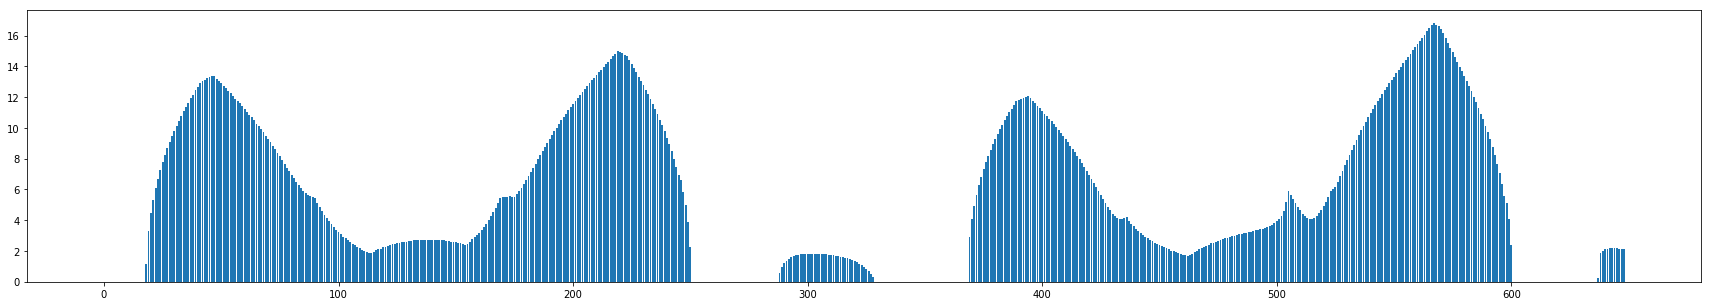

189 0.29121725731895226
1
Simple station-keeping: 0 1 2 3 
beg
end


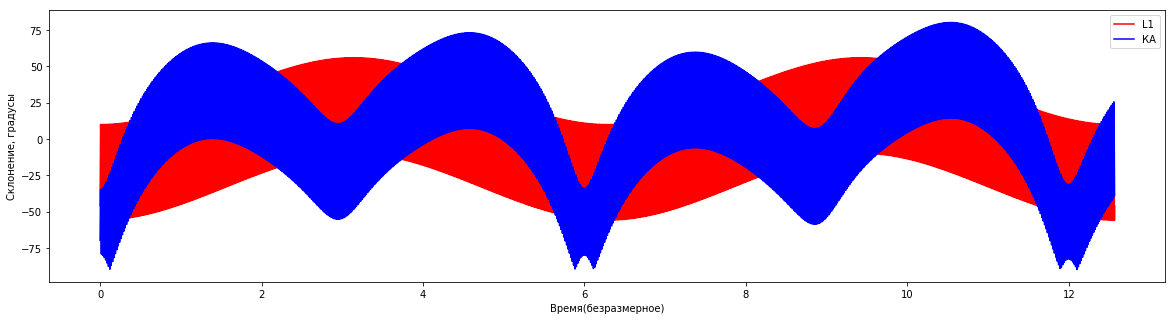

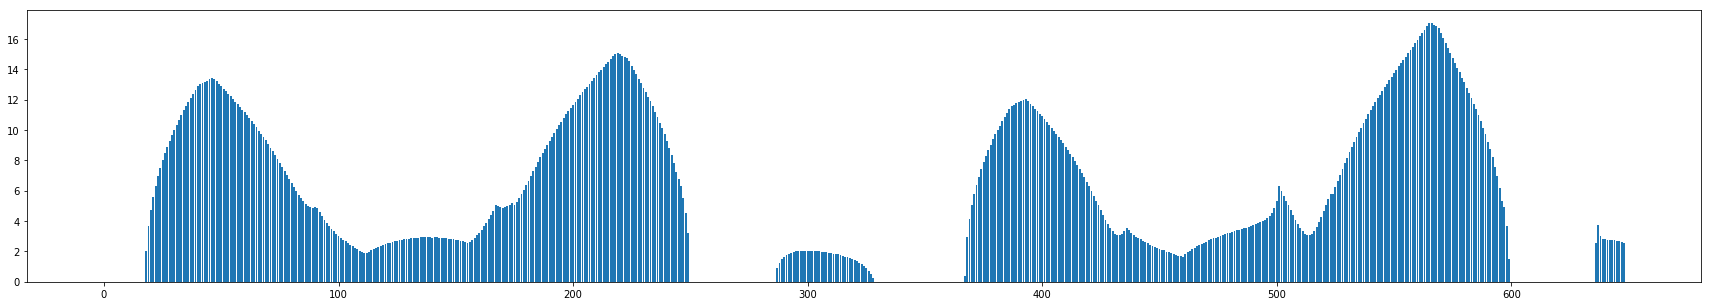

178 0.27426810477657937
2
Simple station-keeping: 0 1 2 3 
beg
end


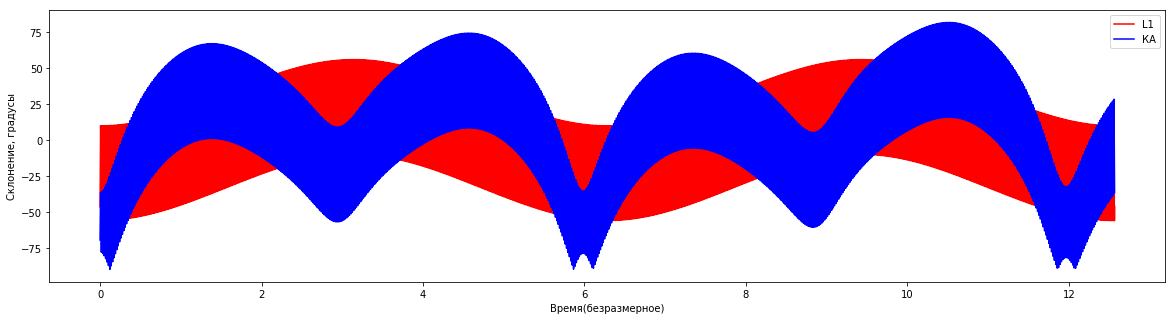

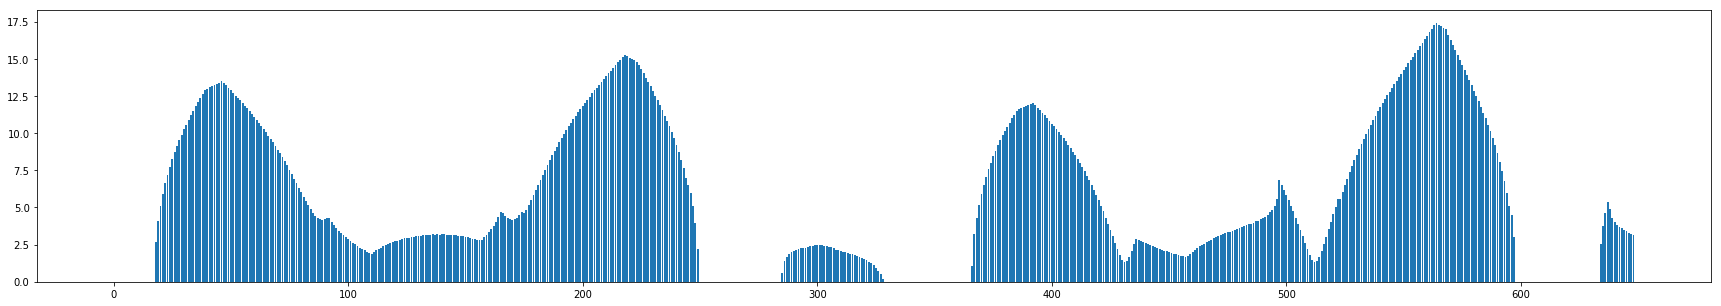

173 0.2665639445300462
3
Simple station-keeping: 0 1 2 3 
beg
end


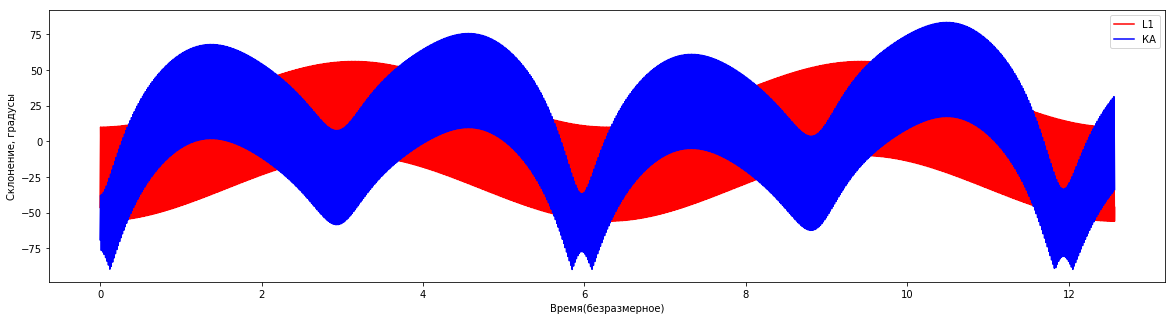

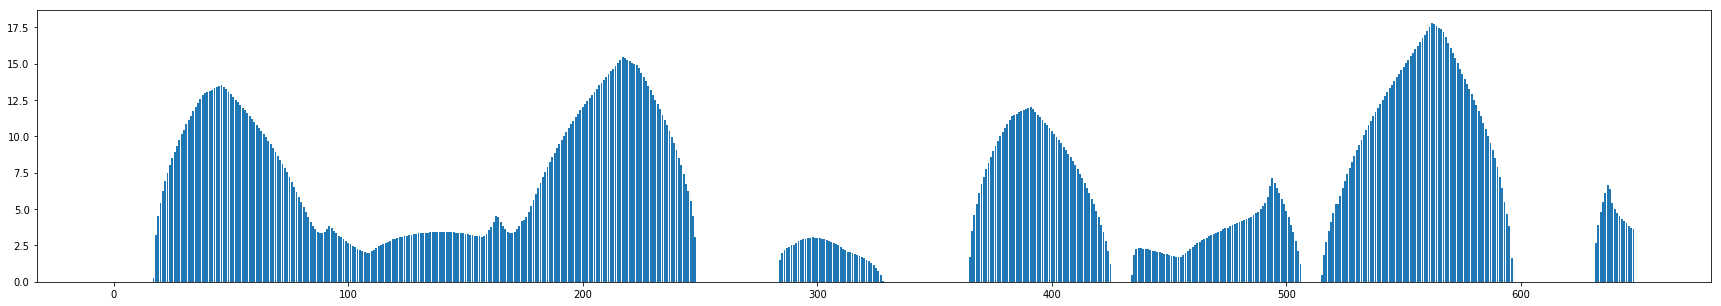

177 0.2727272727272727
4
Simple station-keeping: 0 1 2 3 
beg
end


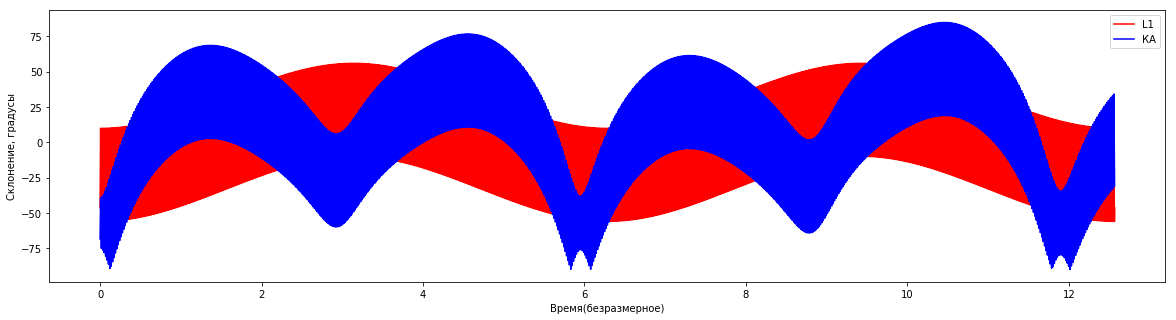

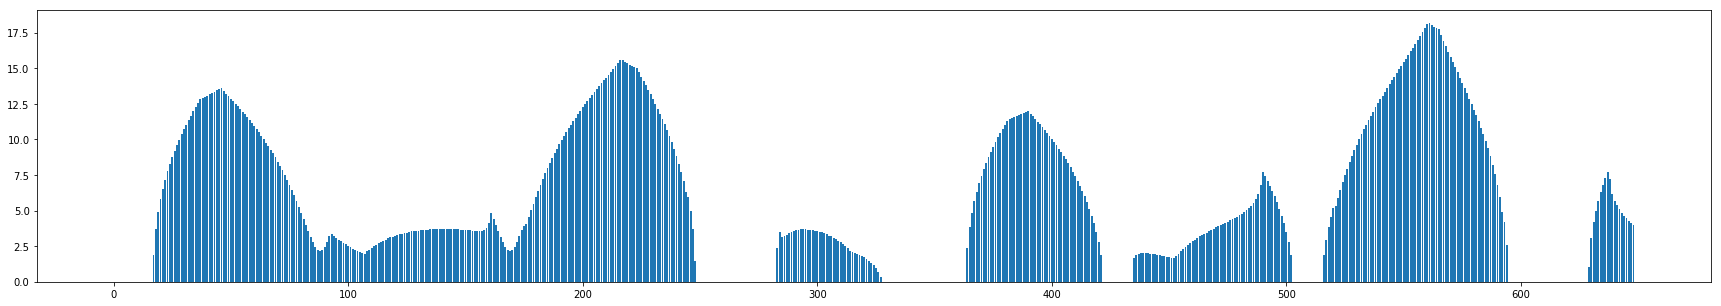

183 0.28197226502311246
5
Simple station-keeping: 0 1 2 3 
beg
end


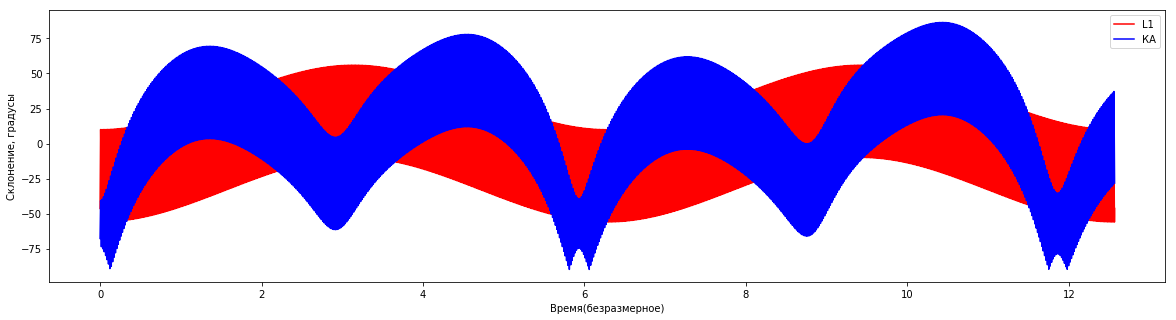

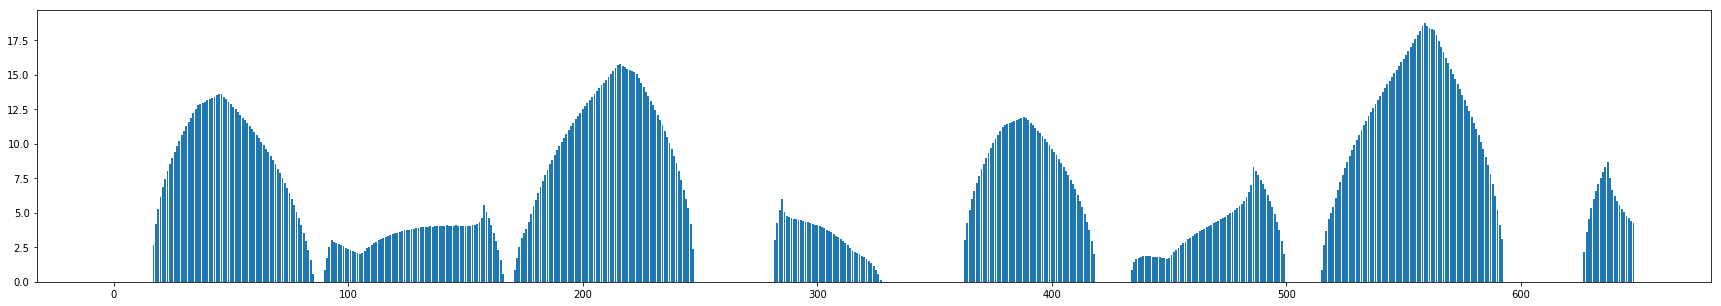

197 0.3035439137134052
6
Simple station-keeping: 0 1 2 3 
beg
end


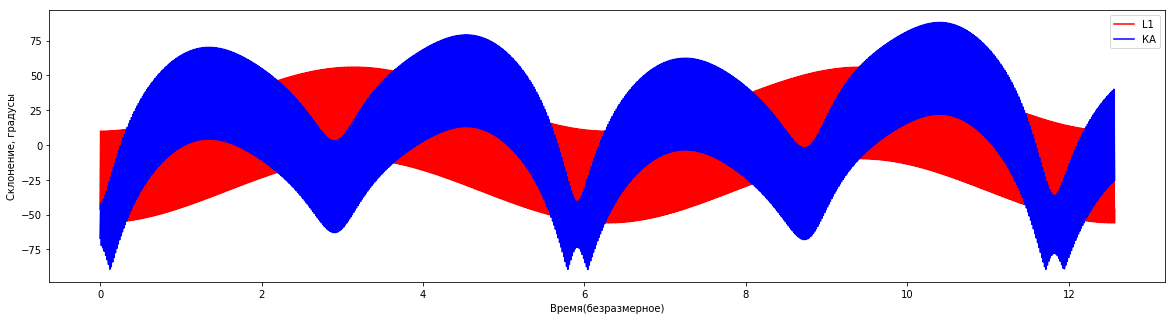

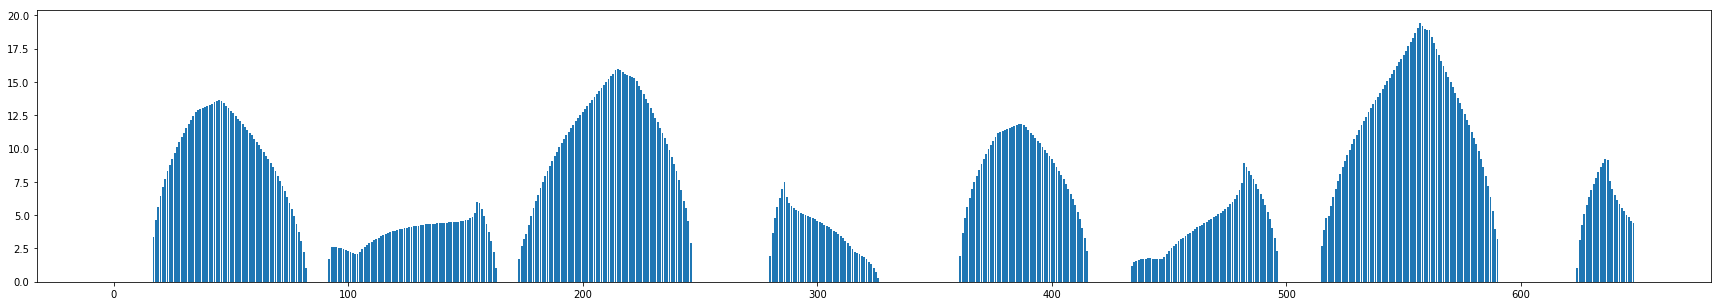

201 0.30970724191063176
7
Simple station-keeping: 0 1 2 3 
beg
end


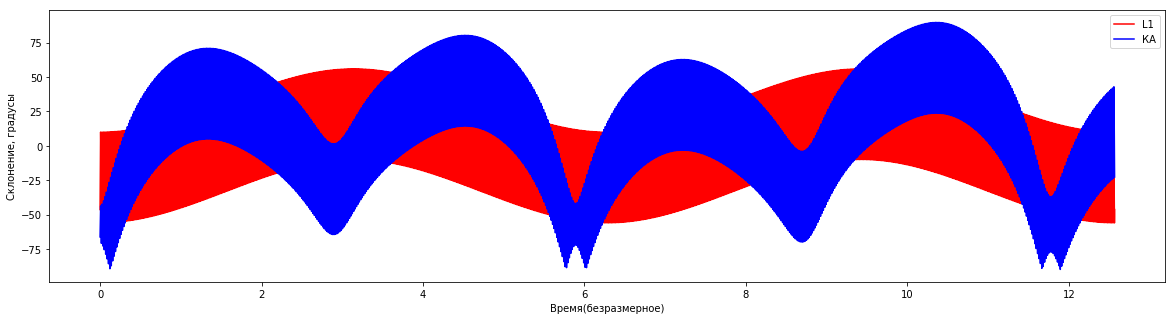

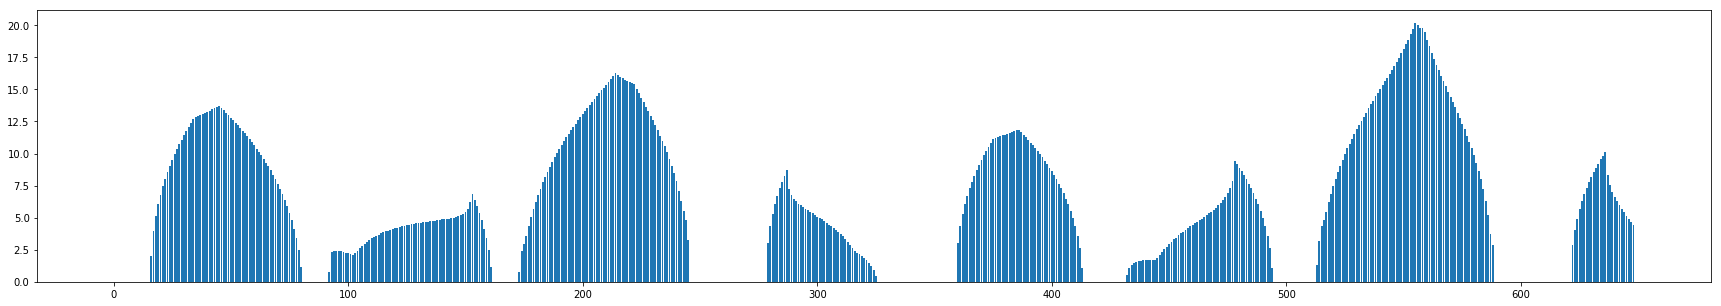

201 0.30970724191063176
8
Simple station-keeping: 0 1 2 3 
beg
end


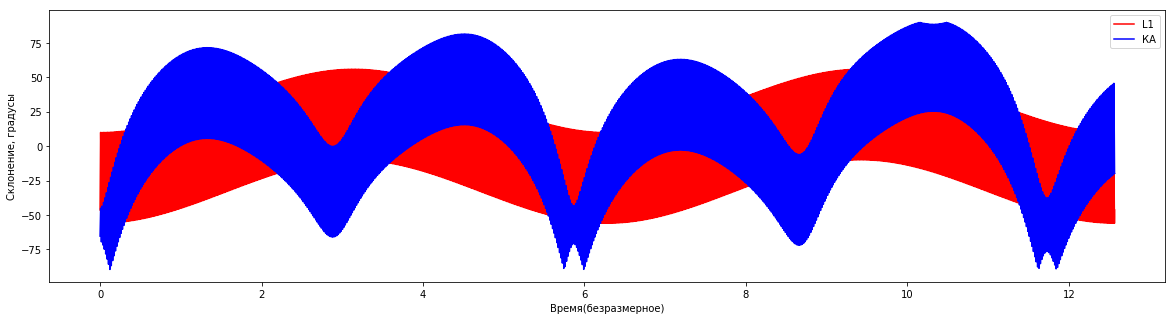

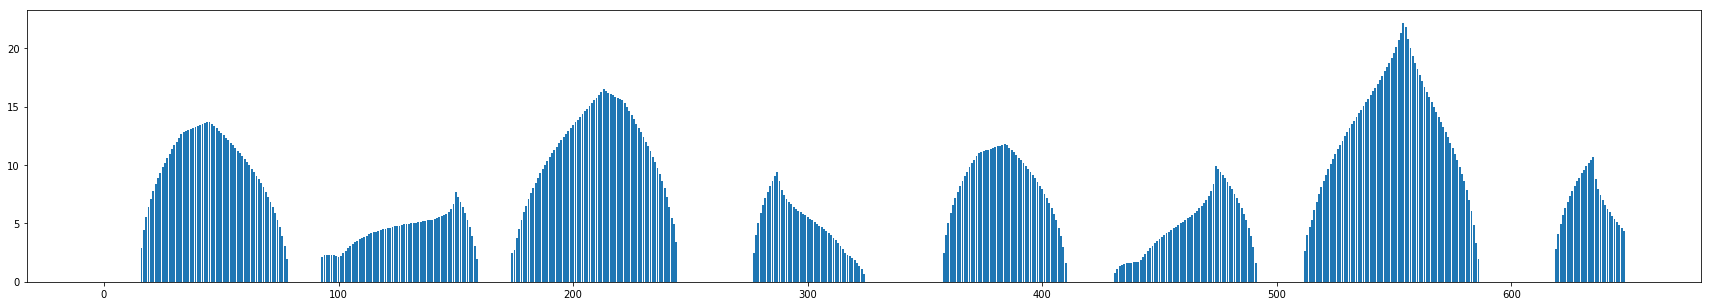

203 0.31278890600924497
9
Simple station-keeping: 0 1 2 3 
beg
end


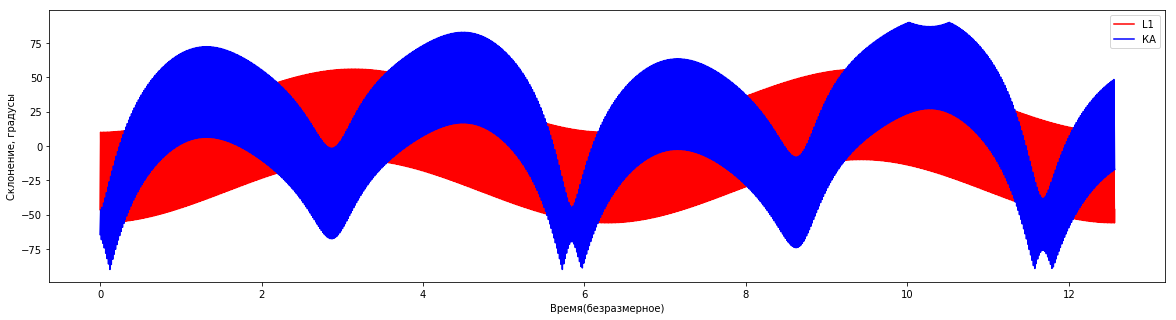

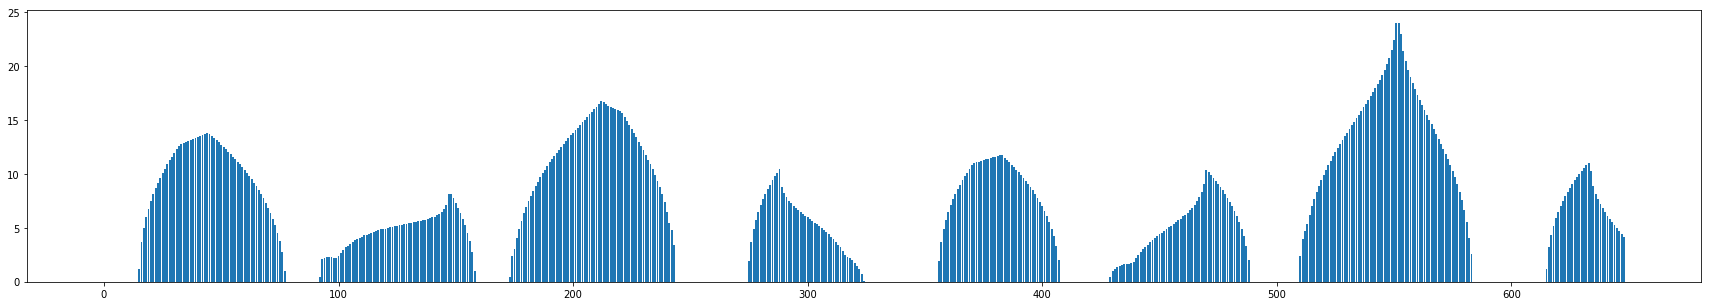

203 0.31278890600924497


In [72]:
for i in range(10):
    ss = model.get_zero_state()
    ss[0] = haloo[1000+50*i, 0]
    ss[2] = haloo[1000+50*i, 1]
    ss[4] = haloo[1000+50*i, 2]
    print(i)
    visibility2(ss, [57,38], 4*np.pi, 81)

In [76]:
halo = halo.loc[~halo.apply(np.round, args=[9]).duplicated()]
spl1 = op.lines.spline.cubic(halo.to_numpy(), usecols=[0, 1])

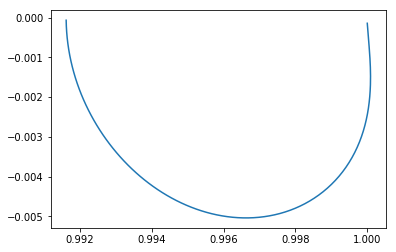

In [86]:
X1 = np.linspace(0,1,200)
points = spl1(X1)[:,:2]
plt.plot(points[:,0],points[:,1])

In [ ]:
visibility2(,[57,38], 2*np.pi, 81)

In [ ]:
class MinDistanceProblem:
    def __init__(self, halo_curve):
        self.spl = op.lines.spline.cubic(halo_curve.to_numpy(), usecols=[0, 1])
        self.dc = op.differential_correction.from_preset(stm_model, 'halo')
        self.center = np.array([(halo_curve.iloc[0]['x']+halo_curve.iloc[-1]['x'])*0.5, 0.0])
        self.vec_axis = np.array([model.mu1 - self.center[0], 0.])
        self.plane = op.eventY(count=2)
        self.det = op.event_detector(precise_model, [self.plane])
        
    def calc_angle(self, a, b):
        vec_orb = np.array([a - self.center[0], b]) # np.array([a, b]) - np.array([self.center, 0.])
        return np.degrees(np.arccos(np.dot(vec_orb, self.vec_axis)/(self.norm(vec_orb)*self.norm(self.vec_axis))))
        
    def norm(self, vec):
        return np.linalg.norm(vec)
        
    def visibility2(self, l, coord, time, delta_t, ax = ax0, alpha = 5):
        df_needed, _ = self.calc_orbit(l)
      
        spl = op.lines.spline.cubic(df_needed[['t','x','y','z']].to_numpy(), usecols=(0,)) 

        tmin = df_needed['t'].iloc[0]
        tmax = df_needed['t'].iloc[-1]

        N = int(scale(time, 'nd-min'))
        dt1 = (tmax-tmin)/N # одна минута*
        dt = scale(dt1, 'nd-min') 
        #print("dt(min) = ", dt)
        array = spl.get_points(N) # интерполяция траектории (координаты на каждую минуту*)
        print('beg')
        norm0 = np.array([math.cos(coord[0]*np.pi/180)*math.cos(coord[1]*np.pi/180), math.cos(coord[0]*np.pi/180)*math.sin(coord[1]*np.pi/180), math.sin(coord[0]*np.pi/180)])
        sc_dec_norm = [] # склонение КА 
        l1_dec_norm = [] # склонение L1
        visibility = []
        for i in range(N): 
            sc_cur1 = array[i]
            sc_dec_norm.append(angle_norm(sc_cur1[1:], norm0, sc_cur1[0])) 
            l1_dec_norm.append(angle_norm(model.L[0], norm0, sc_cur1[0]))
            if (sc_dec_norm[i] >= alpha and sc_dec_norm[i] < 90):
                visibility.append(True)
            else:
                visibility.append(False)
        #
        print('end')

        # сравнение склонений КА и L1   
        plt.figure(figsize = (20,5))
        plt.plot(array[:,0], l1_dec_norm, 'r', label = 'L1')
        plt.plot(array[:,0], sc_dec_norm, 'b', label = 'КА')
        plt.xlabel("Время(безразмерное)")
        plt.ylabel("Склонение, градусы")
        plt.legend()
        #
        visarr = np.array(visibility)
        itog = visarr[0:N - int(scale(delta_t, 'd-min'))] & visarr[int(scale(delta_t, 'd-min')):N] # сдвиг траектории второго КА относительно первого составляет 125000 минут, ,что примерно равно четверти года (половине периода орбиты)
        lenn = len(itog)//(24*60)
        for_bar = itog[:lenn*24*60].reshape(lenn, 24*60)
        YY = np.mean(for_bar, axis = 1)*24
        plt.figure(figsize = (30,5))
        plt.bar(range(lenn),YY)
        plt.show()
        tmp = np.where(YY<=2, 0, YY)
        non_visible = len(tmp) - np.count_nonzero(tmp)
        print(non_visible, non_visible/len(tmp))
        return(visarr)

    
    def calc_orbit(self, length):
        x0, z0, vy0 = self.spl(length)
        alpha = self.calc_angle(x0, z0)
        s0 = self.dc.shoot(np.array([x0, 0., z0, 0., vy0, 0.]), alpha)[:6]
        orb, ev = self.det.prop(s0, 0.0, 100, last_state='last')
        return orb, ev

    def min_distance_length(self, length):
        orb, ev = self.calc_orbit(length)
        half_period = ev.iloc[-1]['t']*0.5
        return self.min_distance(orb, half_period)
    
    